In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime as dt

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from tensorflow import keras
from keras import metrics, initializers
from tensorflow.keras.layers import Dropout,LSTM, GRU, BatchNormalization, Dense, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV, KFold, LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasRegressor

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau

from matplotlib import style
style.use('tableau-colorblind10')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
df = pd.read_csv('Data/bitcoin without lag.csv', parse_dates=['datetime'], index_col=['datetime'])
#df = pd.read_csv('Data/Bitcoin preprocessed.csv', index_col=['datetime'])
df.head()

,high,low,open,volumefrom,volumeto,close,hourly_volume,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,eth_open,eth_close,bnb_open,bnb_close,usdt_open,usdt_close,sol_open,sol_close,hourly_return,3_hourly_return,5_hourly_return,12_hourly_return,3_hourly_volatility,5_hourly_volatility,12_hourly_volatility,daily_volatility,trend_score,Pos_score,Neg_score,Compound_score,Polarity,time_of_the_day,day,day_of_month,weekend
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,20817.65,19647.29,19908.49,6823.65,1.381081e+08,20262.66,143641.30,1.413396e+08,1.734342e+09,1.875681e+09,1.023345e+08,1.014878e+09,1.117212e+09,1.706061e+08,1.915078e+09,2.085684e+09,1069.53,1093.82,219.48,222.58,0.9992,0.9987,33.74,34.44,354.17,1464.85,1379.49,1072.73,493.599288,460.540694,348.583077,286.091957,100.0,0.090867,0.064867,0.115550,0.0,0.0,Friday,1,0
2022-07-01 01:00:00,20444.21,20231.53,20262.66,3183.32,6.471331e+07,20380.14,64012.17,6.423249e+07,8.010797e+08,8.653122e+08,4.611965e+07,4.423495e+08,4.884692e+08,8.518715e+07,8.941570e+08,9.793442e+08,1093.82,1095.07,222.58,225.22,0.9987,0.9985,34.44,34.87,117.48,1506.73,1646.43,1531.40,476.384009,411.796784,321.143744,286.846382,113.0,0.098000,0.066744,0.034856,0.0,1.0,Friday,1,0
2022-07-01 02:00:00,20504.52,20238.04,20380.14,2262.26,4.603065e+07,20266.86,48773.36,4.844529e+07,5.490071e+08,5.974524e+08,3.446238e+07,3.276693e+08,3.621317e+08,7.538542e+07,6.256688e+08,7.010542e+08,1095.07,1091.22,225.22,225.60,0.9985,0.9982,34.87,34.77,-113.28,358.37,1469.05,1165.98,233.731269,446.529586,325.557403,287.855508,92.0,0.132773,0.042909,0.103223,0.0,2.0,Friday,1,0
2022-07-01 03:00:00,20276.63,19668.22,20266.86,3603.45,7.212081e+07,19703.32,65925.93,5.869008e+07,8.222572e+08,8.809473e+08,4.438665e+07,4.956181e+08,5.400048e+08,7.742932e+07,9.239673e+08,1.001397e+09,1091.22,1053.55,225.60,220.97,0.9982,0.9980,34.77,33.61,-563.54,-559.34,829.91,583.05,346.355426,592.302312,377.555379,310.682042,90.0,0.109960,0.044840,0.166612,0.0,3.0,Friday,1,0
2022-07-01 04:00:00,19713.40,19352.87,19703.32,3932.58,7.685356e+07,19376.97,84503.60,7.795704e+07,2.074082e+09,2.152039e+09,5.267009e+07,6.085733e+08,6.612434e+08,1.007285e+08,2.285414e+09,2.386143e+09,1053.55,1048.59,220.97,219.20,0.9980,0.9981,33.61,32.55,-326.35,-1003.17,-531.52,257.76,225.237648,360.433506,392.813183,317.146276,97.0,0.093640,0.058400,0.132120,0.0,4.0,Friday,1,0


In [4]:
df = df.drop(['Pos_score', 'Neg_score', 'eth_open', 'eth_close', 'bnb_open', 'bnb_close', 'usdt_open',
              'usdt_close', 'sol_open', 'sol_close'], axis = 1)

### Feature Engineering

In [5]:
df['day'].unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

In [6]:
df['day_of_week'] = 1
for i in range(len(df.index)):
    if df['day'][i] == 'Sunday':
        df['day_of_week'][i] = 1
    elif df['day'][i] == 'Monday':
        df['day_of_week'][i] = 2
    elif df['day'][i] == 'Tuesday':
        df['day_of_week'][i] = 3
    elif df['day'][i] == 'Wednesday':
        df['day_of_week'][i] = 4
    elif df['day'][i] == 'Thursday':
        df['day_of_week'][i] = 5
    elif df['day'][i] == 'Friday':
        df['day_of_week'][i] = 6
    elif df['day'][i] == 'Saturday':
        df['day_of_week'][i] = 7

In [7]:
df.drop('day', axis = 1, inplace = True)
df['hourly_return'] = 0
for i in range(1, len(df.index)):
    df['hourly_return'][i] = df['close'][i] - df['close'][i-1]

In [8]:
df.head()

,high,low,open,volumefrom,volumeto,close,hourly_volume,top_tier_volume_quote,top_tier_volume_base,top_tier_volume_total,cccagg_volume_quote,cccagg_volume_base,cccagg_volume_total,total_volume_quote,total_volume_base,total_volume_total,hourly_return,3_hourly_return,5_hourly_return,12_hourly_return,3_hourly_volatility,5_hourly_volatility,12_hourly_volatility,daily_volatility,trend_score,Compound_score,Polarity,time_of_the_day,day_of_month,weekend,day_of_week
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-01 00:00:00,20817.65,19647.29,19908.49,6823.65,1.381081e+08,20262.66,143641.30,1.413396e+08,1.734342e+09,1.875681e+09,1.023345e+08,1.014878e+09,1.117212e+09,1.706061e+08,1.915078e+09,2.085684e+09,0.00,1464.85,1379.49,1072.73,493.599288,460.540694,348.583077,286.091957,100.0,0.115550,0.0,0.0,1,0,6
2022-07-01 01:00:00,20444.21,20231.53,20262.66,3183.32,6.471331e+07,20380.14,64012.17,6.423249e+07,8.010797e+08,8.653122e+08,4.611965e+07,4.423495e+08,4.884692e+08,8.518715e+07,8.941570e+08,9.793442e+08,117.48,1506.73,1646.43,1531.40,476.384009,411.796784,321.143744,286.846382,113.0,0.034856,0.0,1.0,1,0,6
2022-07-01 02:00:00,20504.52,20238.04,20380.14,2262.26,4.603065e+07,20266.86,48773.36,4.844529e+07,5.490071e+08,5.974524e+08,3.446238e+07,3.276693e+08,3.621317e+08,7.538542e+07,6.256688e+08,7.010542e+08,-113.28,358.37,1469.05,1165.98,233.731269,446.529586,325.557403,287.855508,92.0,0.103223,0.0,2.0,1,0,6
2022-07-01 03:00:00,20276.63,19668.22,20266.86,3603.45,7.212081e+07,19703.32,65925.93,5.869008e+07,8.222572e+08,8.809473e+08,4.438665e+07,4.956181e+08,5.400048e+08,7.742932e+07,9.239673e+08,1.001397e+09,-563.54,-559.34,829.91,583.05,346.355426,592.302312,377.555379,310.682042,90.0,0.166612,0.0,3.0,1,0,6
2022-07-01 04:00:00,19713.40,19352.87,19703.32,3932.58,7.685356e+07,19376.97,84503.60,7.795704e+07,2.074082e+09,2.152039e+09,5.267009e+07,6.085733e+08,6.612434e+08,1.007285e+08,2.285414e+09,2.386143e+09,-326.35,-1003.17,-531.52,257.76,225.237648,360.433506,392.813183,317.146276,97.0,0.132120,0.0,4.0,1,0,6


In [9]:
# # Generating sine and cosine functions
# hour = 60*60
# day = 24*hour

# df['Hour sin'] = np.sin(df.time_of_the_day * (2 * np.pi / hour))
# df['Hour cos'] = np.cos(df.time_of_the_day * (2 * np.pi / hour))
# df['Day sin'] = np.sin(df.day_of_week * (2 * np.pi / day))
# df['Day cos'] = np.cos(df.day_of_week * (2 * np.pi / day))

### EDA

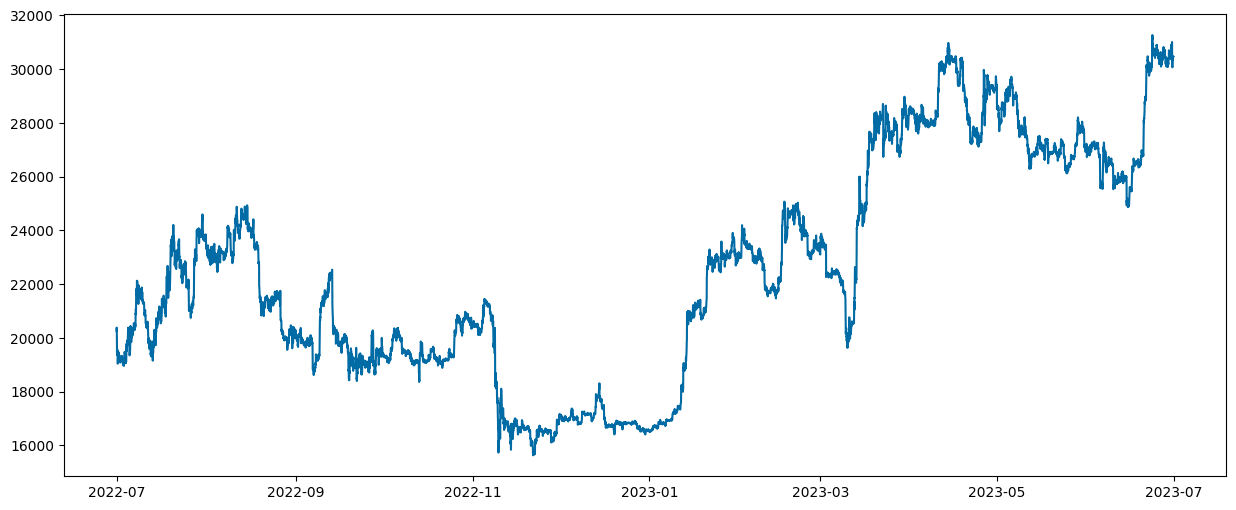

In [10]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['close'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

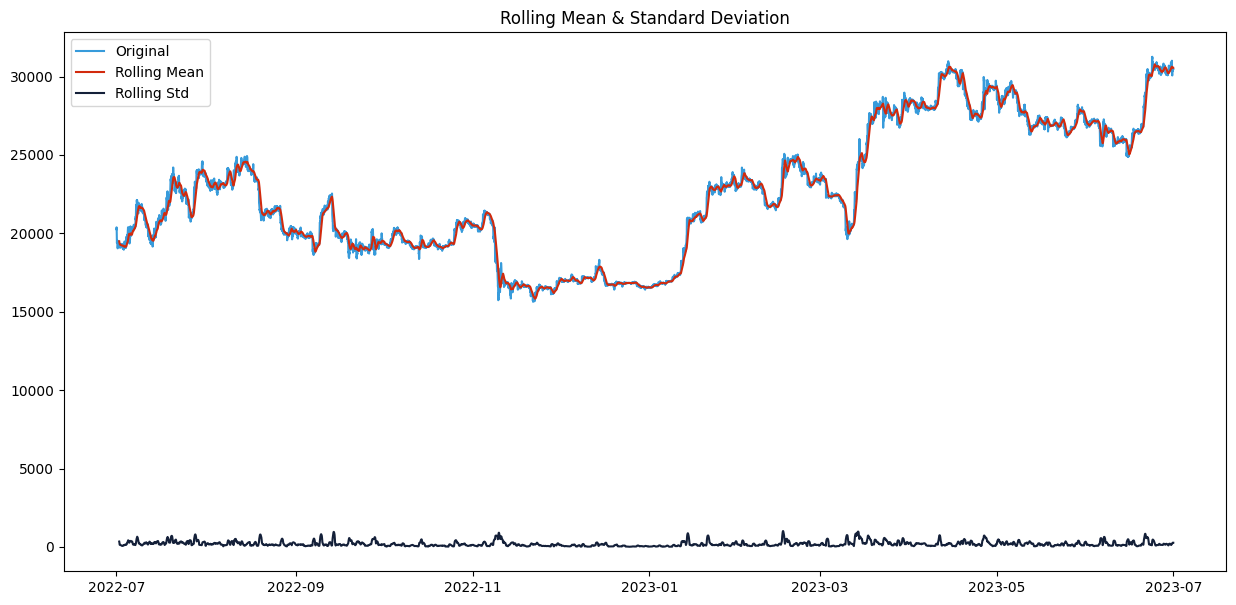

In [11]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["close"], color='#379BDB', label='Original')
plt.plot(df["close"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["close"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

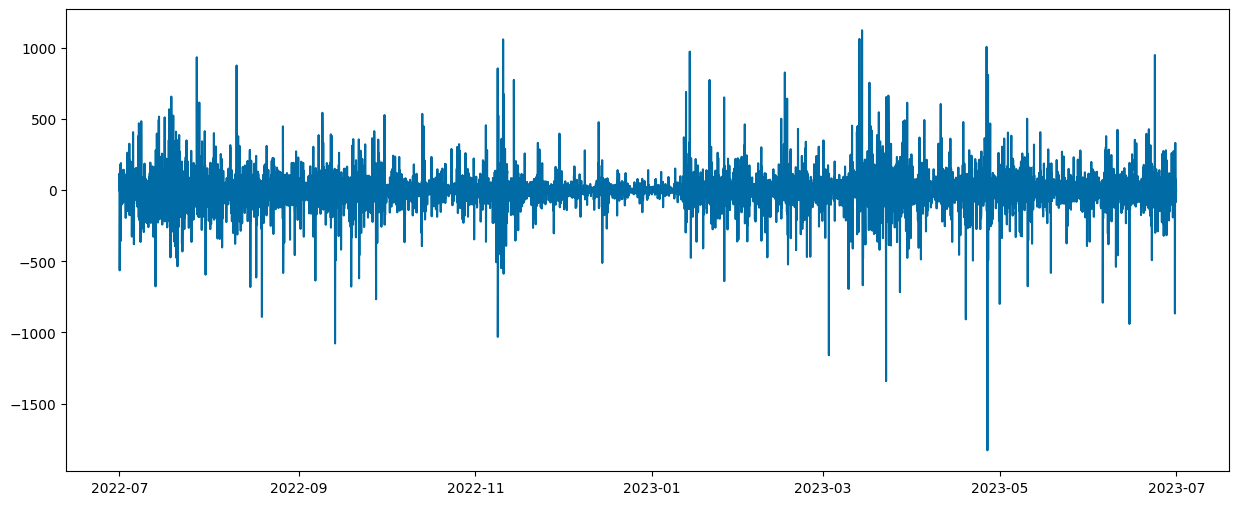

In [12]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['hourly_return'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

<Axes: xlabel='close', ylabel='Count'>

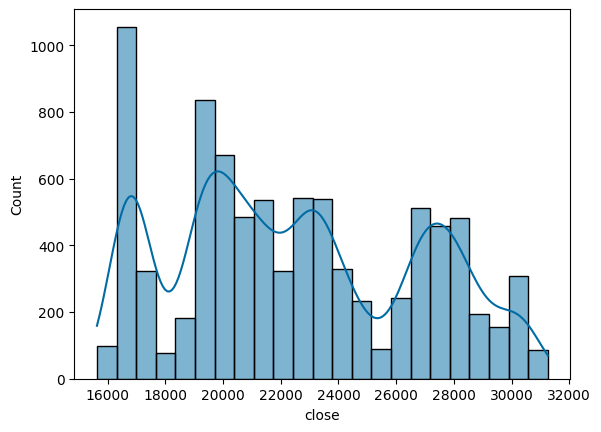

In [13]:
sns.histplot(data = df['close'], kde=True)

<Axes: xlabel='close', ylabel='Count'>

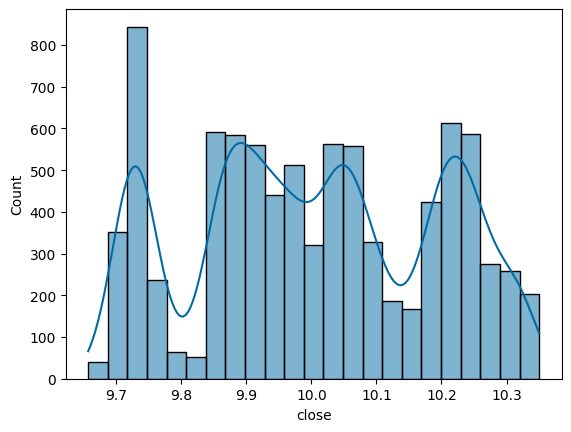

In [14]:
sns.histplot(data = np.log(df['close']), kde = True)

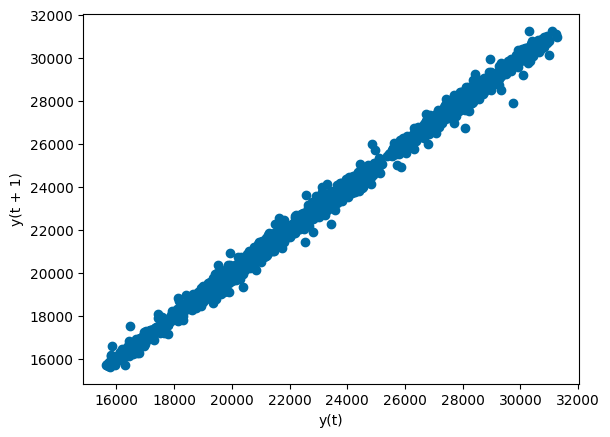

In [15]:
from pandas.plotting import lag_plot

lag_plot(df['close'])
plt.show()

In [16]:
# Checking auto-correlation
from pandas import concat

btc_price = df['close']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000000,0.999552
t+1,0.999552,1.000000


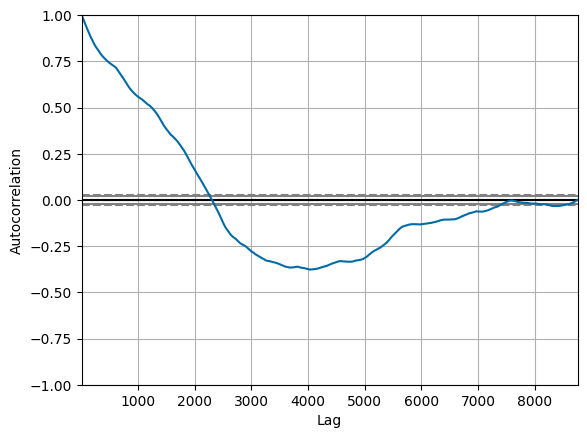

In [17]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['close'])
plt.show()

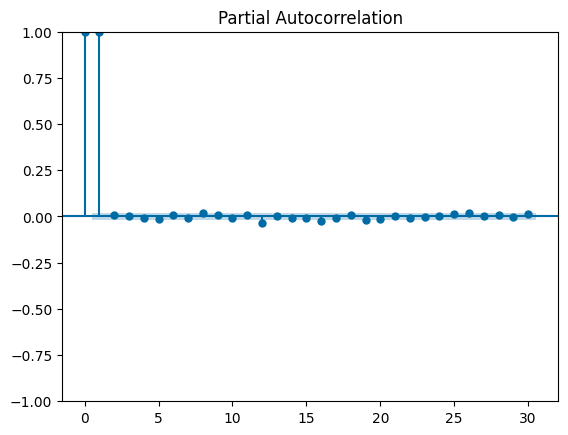

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df['close'], lags=30)
plt.show()

### Data transformation

In [19]:
#moving column to end
cols_at_end = ['close']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]

In [20]:
# Functions for transformation

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def robust_transform(train_data, test_data, target_col = 'close'):
    cols = [x for x in train_data.columns if x != target_col]
    enc1 = RobustScaler()
    a = train_data.copy()
    b = test_data.copy()
    a[cols] = enc1.fit_transform(a[cols])
    b[cols] = enc1.transform(b[cols])
    
    enc2 = RobustScaler()
    a[[target_col]] = enc2.fit_transform(a[[target_col]])
    b[[target_col]] = enc2.transform(b[[target_col]])

    return a, b, enc2

In [21]:
def lag_generator(data, windows):
    np_data = data.to_numpy()
    X = []
    y = []
    for j in range(len(np_data) - windows):
        row = [r for r in np_data[j : j + windows]]
        X.append(row)
        label = np_data[j + windows] #change here
        y.append(label)
        
    return np.array(X), np.array(y)

def lag_generator_1out(data, windows):
    np_data = data.to_numpy()
    X = []
    y = []
    for k in range(len(np_data) - windows):
        row = [a for a in np_data[k : k + windows]]
        X.append(row)
        label = np_data[k + windows][-1] #change here
        y.append(label)
        
    return np.array(X), np.array(y)

def lag_generator_1d(data, windows):
    np_data = data.copy()
    X = []
    y = []
    for i in range(len(np_data.index) - windows):
        row = np_data.iloc[i : i + windows].to_numpy()
        ele = row[0]
        for j in range(1, len(row)):
            ele = np.append(ele, row[j])
        X.append(ele)
        label = np_data.iloc[i + windows] #change here
        y.append(label)
        
    return np.array(X), np.array(y)

def lag_generator_1d_1output(data, windows):
    X = []
    y = []
    for i in range(len(data.index) - windows):
        row = data.iloc[i : i + windows].to_numpy()
        ele = row[0]
        for j in range(1, len(row)):
            ele = np.append(ele, row[j])
        X.append(ele)
        label = [data.iloc[i + windows][-1]] #change here
        y.append(label)
        
    return np.array(X), np.array(y)

In [22]:
# MDAPE
import statistics
from sklearn.metrics import mean_squared_error, r2_score

def MAPE(actual, pred):
    assert len(actual) == len(pred), "Input arrays must have the same length."
    absolute_errors = np.abs((actual - pred) / actual)
    mdape = np.mean(absolute_errors) * 100.0

    return mdape

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [23]:
# Creating a function for running models with k-fold cross validation
from sklearn.model_selection import TimeSeriesSplit

def run_model(model, k_num, feature, label):
    
    # Create indices for folds using 'KFold' function
    tscv = TimeSeriesSplit(n_splits = k_num)
    
    # Define evaluation matrices for cross validation
    scoring = ['neg_mean_squared_error', 'r2']
    
    # Initiate model training with corss validation and return the scores
    scores = cross_validate(model, feature, label, scoring = scoring, cv = tscv)
    
    return np.mean(scores['test_neg_mean_squared_error']) , np.mean(scores['test_r2'])

### Splitting data

In [24]:
df.columns

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'hourly_volume',
       'top_tier_volume_quote', 'top_tier_volume_base',
       'top_tier_volume_total', 'cccagg_volume_quote', 'cccagg_volume_base',
       'cccagg_volume_total', 'total_volume_quote', 'total_volume_base',
       'total_volume_total', 'hourly_return', '3_hourly_return',
       '5_hourly_return', '12_hourly_return', '3_hourly_volatility',
       '5_hourly_volatility', '12_hourly_volatility', 'daily_volatility',
       'trend_score', 'Compound_score', 'Polarity', 'time_of_the_day',
       'day_of_month', 'weekend', 'day_of_week', 'close'],
      dtype='object')

In [25]:
df = df[['high', 'low', 'open', 'volumefrom', 'volumeto', 'hourly_volume', 'hourly_return', 'trend_score', 'Compound_score',
         'Polarity', 'time_of_the_day','day_of_month', 'weekend', 'day_of_week', 'close']]

In [26]:
train = df.iloc[:len(df.index) - (500)]
test = df.iloc[len(df.index) - 500:]

In [27]:
scaled_train, scaled_test, universal_y_enc = robust_transform(train, test, target_col = 'close')

In [28]:
x_col = scaled_train.drop('close', axis = 1).values
y_col = scaled_train[['close']].values

### Feature selection

<Axes: >

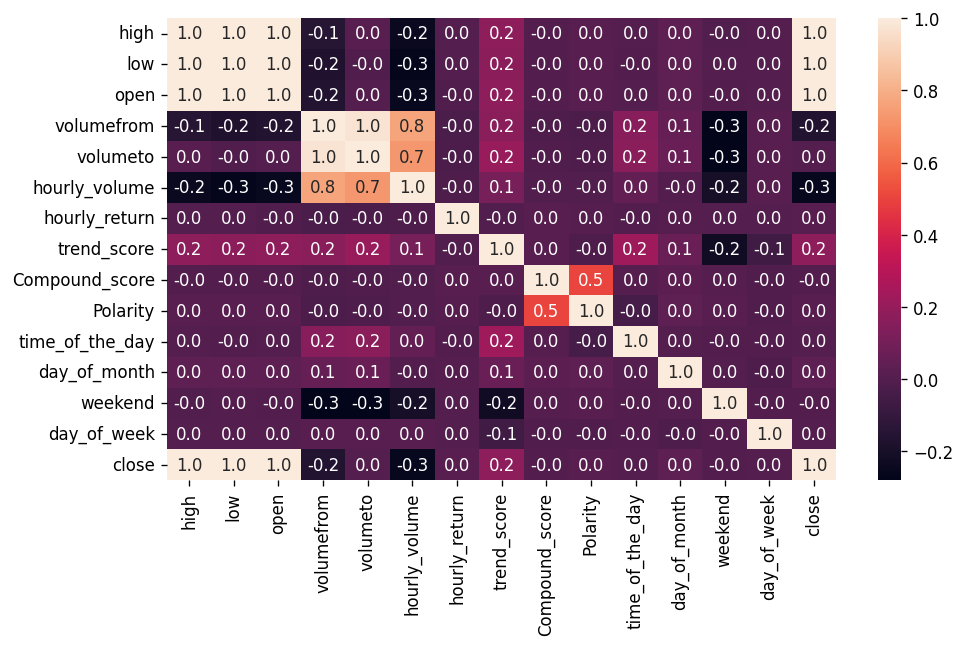

In [29]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (9,5), dpi = 120)
sns.heatmap(scaled_train.corr(), annot = True, fmt = '.1f')

In [30]:
X1 = scaled_train.drop('close', axis = 1)
Y1 = scaled_train[['close']]

In [31]:
from sklearn.linear_model import Lasso
n_folds = 10
ts_folds = TimeSeriesSplit(n_splits = 10)

In [32]:
# range of alpha value to be tested for GridSearchCV
params = {"alpha":np.linspace(1e-5, 10, num = 500)}

# Create a lasso object
lasso_model = Lasso()

# GridSearchCV with lasso object, params and folds.
lasso_grid = GridSearchCV(lasso_model, param_grid = params, cv = ts_folds)
lasso_grid.fit(X1, Y1)
print(lasso_grid.best_params_)

{'alpha': 1e-05}


In [33]:
# Get column names from dataset

col_names = X1.columns
print(col_names.values)

['high' 'low' 'open' 'volumefrom' 'volumeto' 'hourly_volume'
 'hourly_return' 'trend_score' 'Compound_score' 'Polarity'
 'time_of_the_day' 'day_of_month' 'weekend' 'day_of_week']


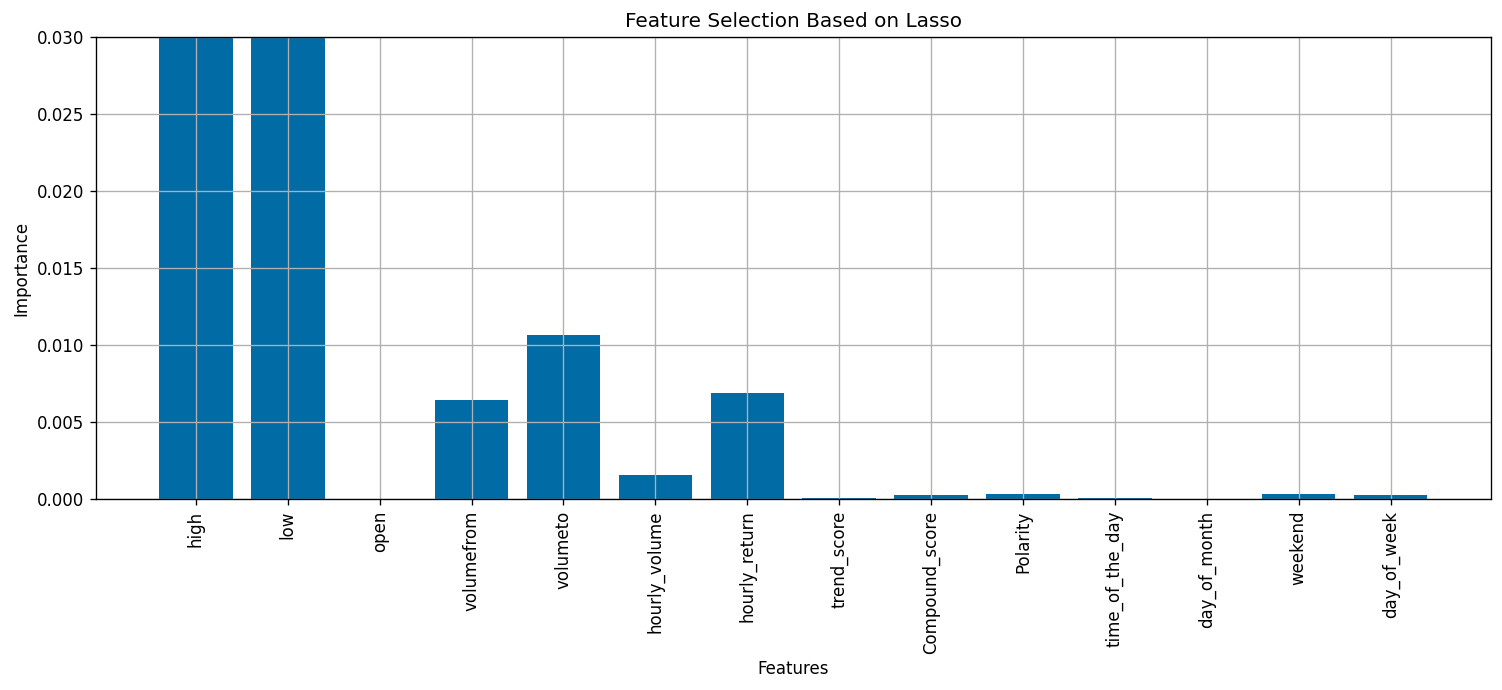

In [34]:
# Create lasso object with best alpha value and fit on data
lasso_model = Lasso(alpha = 1e-5)
lasso_model.fit(X1, Y1)

# Make all coefficients positive and create one variable
lasso_coef = np.abs(lasso_model.coef_)

# Plot lasso coefficients for all columns

# Set figure size and dpi
plt.figure(figsize = (15,5), dpi = 120)

# Plot a bar graph with lasso coefficient and column names
plt.bar(col_names, lasso_coef)

# Rotate labels on x-axis by 90 degrees
plt.xticks(rotation = 90)

# Hide grid lines
plt.grid()

# Set title and labels for both axes
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")

# Set limit for y-axis
plt.ylim(0, 0.03)

# Print the graph
plt.show()

### Machine learning

### Linear Regression

In [35]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

In [36]:
x_train.shape, y_train.shape

((8259, 15), (8259, 1))

In [37]:
from sklearn.linear_model import Ridge
ts_folds = TimeSeriesSplit(n_splits = 10) 

In [38]:
from sklearn.linear_model import Ridge
def linear_regression(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    regressor = Ridge()
    LR_mae, LR_r2 = run_model(regressor, n_folds, x_set, y_set)
    return round(LR_mae , 5), round(LR_r2, 5)

In [39]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 26):
    LR_error, LR_R2 = linear_regression(scaled_train, i)
    error_list.append(LR_error)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(LR_error) + " & R^2 : " + str(LR_R2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
lr_best_lag = lag_list[ind]
print("==========LR results==========")
print("Best lag: ", str(lr_best_lag))

Lag:  1  Error : -0.00046 & R^2 : 0.98325
Lag:  2  Error : -0.00046 & R^2 : 0.9833
Lag:  3  Error : -0.00046 & R^2 : 0.98311
Lag:  4  Error : -0.00046 & R^2 : 0.98308
Lag:  5  Error : -0.00047 & R^2 : 0.98295
Lag:  6  Error : -0.00049 & R^2 : 0.98251
Lag:  7  Error : -0.0005 & R^2 : 0.98233
Lag:  8  Error : -0.0005 & R^2 : 0.98215
Lag:  9  Error : -0.00051 & R^2 : 0.98199
Lag:  10  Error : -0.00051 & R^2 : 0.98192
Lag:  11  Error : -0.00051 & R^2 : 0.98185
Lag:  12  Error : -0.00053 & R^2 : 0.9815
Lag:  13  Error : -0.00053 & R^2 : 0.98147
Lag:  14  Error : -0.00054 & R^2 : 0.98128
Lag:  15  Error : -0.00054 & R^2 : 0.98112
Lag:  16  Error : -0.00055 & R^2 : 0.98103
Lag:  17  Error : -0.00055 & R^2 : 0.98087
Lag:  18  Error : -0.00056 & R^2 : 0.9807
Lag:  19  Error : -0.00056 & R^2 : 0.98065
Lag:  20  Error : -0.00057 & R^2 : 0.98036
Lag:  21  Error : -0.00057 & R^2 : 0.98025
Lag:  22  Error : -0.00057 & R^2 : 0.98019
Lag:  23  Error : -0.00057 & R^2 : 0.98012
Lag:  24  Error : -0.0005

In [50]:
from sklearn.linear_model import LinearRegression
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

model = LinearRegression()

model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [51]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

In [52]:
rmse_error, mape_error, r2

(130.6347217116521, 0.2860267672149419, 0.9964151786391812)

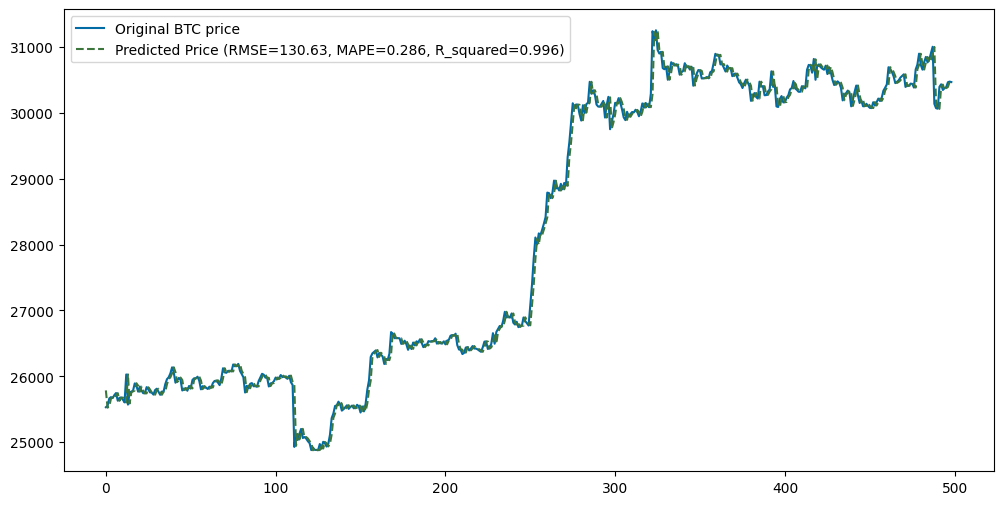

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y, label = 'Original BTC price')
ax.plot(pred, linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

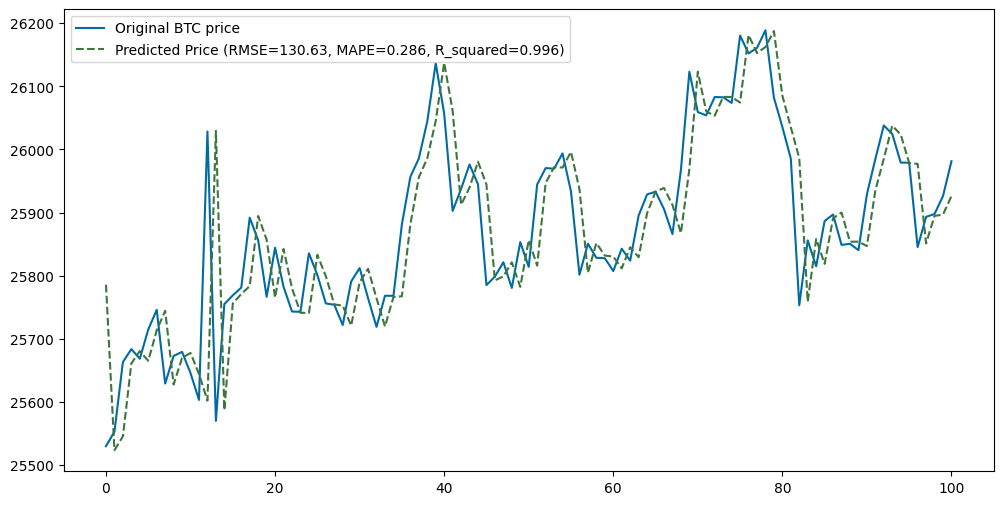

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

In [44]:
model = Ridge()
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [45]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

In [46]:
rmse_error, mape_error, r2

(131.94325746040286, 0.28983707839640455, 0.9963430024142166)

In [47]:
from sklearn.linear_model import Lasso
model = Lasso()
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = universal_y_enc.inverse_transform(pred.reshape(-1,1))
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [48]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

In [49]:
rmse_error, mape_error, r2

(6324.183191404447, 20.629719592887668, -7.401544905431548)

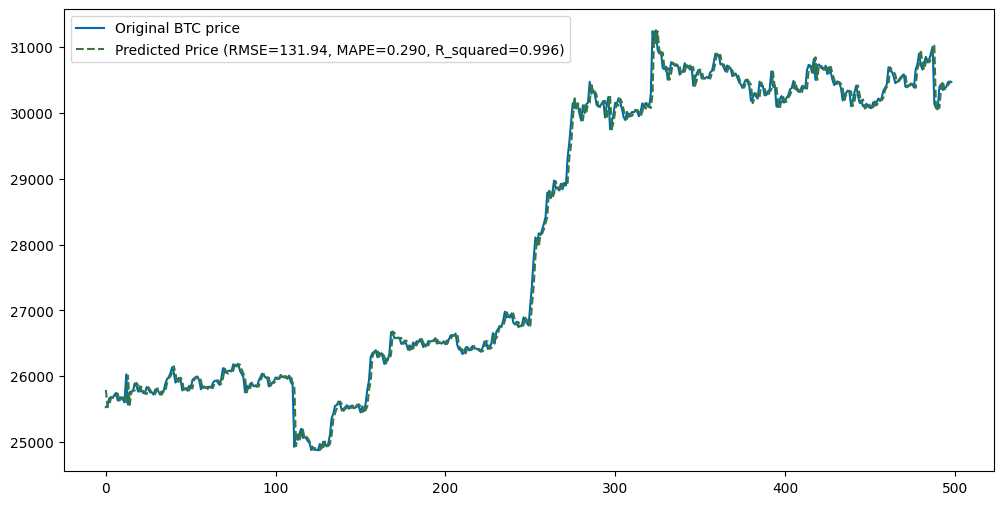

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y, label = 'Original BTC price')
ax.plot(pred, linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

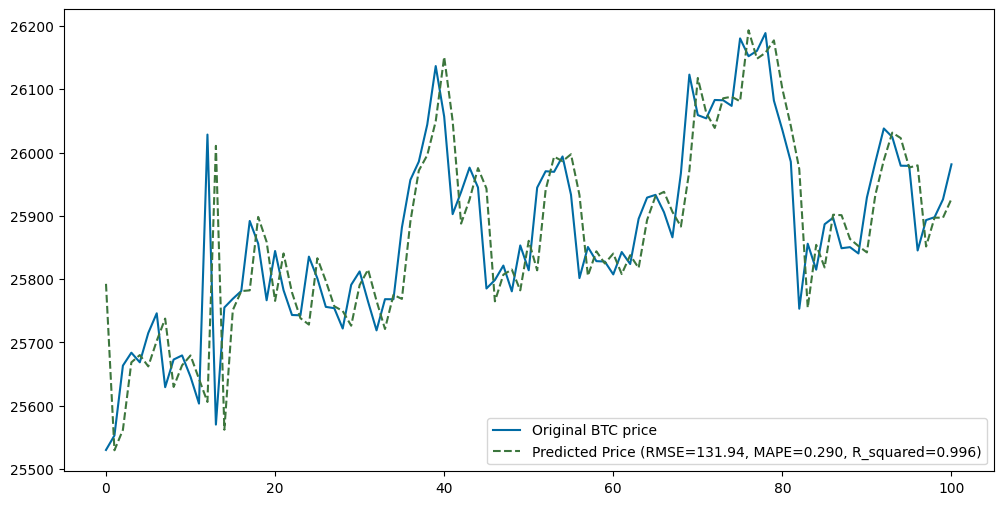

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### SVR

In [34]:
from sklearn.svm import SVR

def svr_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = SVR()
    SVR_mae, SVR_r2 = run_model(model, n_folds, x_set, y_set)
    return round(SVR_mae , 5), round(SVR_r2, 5)

In [45]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 26):
    SVR_mae, SVR_r2 = svr_lag_search(scaled_train, i)
    error_list.append(SVR_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(SVR_mae) + " & R^2 : " + str(SVR_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
svr_best_lag = lag_list[ind]
print("==========SVR results==========")
print("Best lag: ", str(svr_best_lag))

Lag:  1  Error : -0.0816 & R^2 : -0.14028
Lag:  2  Error : -0.08927 & R^2 : -0.34214
Lag:  3  Error : -0.09753 & R^2 : -0.44159
Lag:  4  Error : -0.10514 & R^2 : -0.55019
Lag:  5  Error : -0.10878 & R^2 : -0.6058
Lag:  6  Error : -0.11089 & R^2 : -0.65983
Lag:  7  Error : -0.11419 & R^2 : -0.70138
Lag:  8  Error : -0.11532 & R^2 : -0.6903
Lag:  9  Error : -0.11616 & R^2 : -0.6779
Lag:  10  Error : -0.11692 & R^2 : -0.65057
Lag:  11  Error : -0.11824 & R^2 : -0.66457
Lag:  12  Error : -0.11948 & R^2 : -0.67979
Lag:  13  Error : -0.1204 & R^2 : -0.68733
Lag:  14  Error : -0.12119 & R^2 : -0.70541


KeyboardInterrupt: 

In [46]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"C":np.linspace(1e-1, 15, num = 20), "epsilon":np.linspace(1e-3, 1, num = 5)}

# Create an object of SVR
SVM_model = SVR()

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
SVM_grid = GridSearchCV(SVM_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
SVM_grid.fit(x_train, y_train)

# Store best parameters in variables
best_c = SVM_grid.best_params_['C']
best_epsilon = SVM_grid.best_params_['epsilon']

In [47]:
best_c, best_epsilon

(11.078947368421053, 0.001)

In [36]:
best_c = 11.078947368421053
best_epsilon = 0.001

In [37]:
# Use the above defined variables to create SVM object
model = SVR(C = best_c, epsilon = best_epsilon)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [38]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

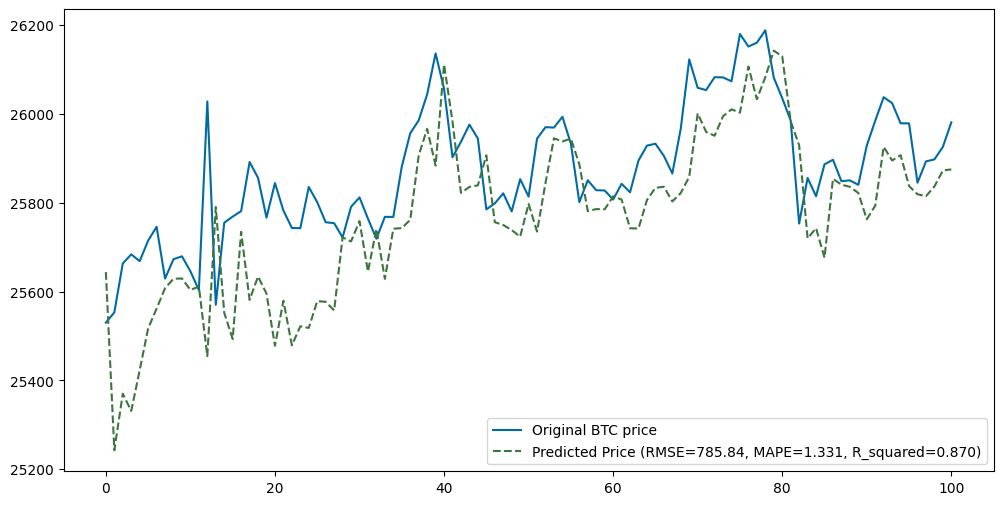

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### KNN

In [40]:
from sklearn.neighbors import KNeighborsRegressor

def knn_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = KNeighborsRegressor()
    KNN_mae, KNN_r2 = run_model(model, n_folds, x_set, y_set)
    return round(KNN_mae , 5), round(KNN_r2, 5)

In [52]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 26):
    KNN_mae, KNN_r2 = knn_lag_search(scaled_train, i)
    error_list.append(KNN_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(KNN_mae) + " & R^2 : " + str(KNN_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
knn_best_lag = lag_list[ind]
print("==========KNN results==========")
print("Best lag: ", str(knn_best_lag))

Lag:  1  Error : -0.18986 & R^2 : -6.77145
Lag:  2  Error : -0.20804 & R^2 : -7.53595
Lag:  3  Error : -0.2176 & R^2 : -7.80129
Lag:  4  Error : -0.22256 & R^2 : -7.98965
Lag:  5  Error : -0.22231 & R^2 : -8.09781
Lag:  6  Error : -0.22291 & R^2 : -8.1917
Lag:  7  Error : -0.22186 & R^2 : -8.16415
Lag:  8  Error : -0.22087 & R^2 : -8.11565
Lag:  9  Error : -0.22046 & R^2 : -8.02798
Lag:  10  Error : -0.22044 & R^2 : -8.04718
Lag:  11  Error : -0.22087 & R^2 : -8.03263
Lag:  12  Error : -0.21968 & R^2 : -8.27043
Lag:  13  Error : -0.22027 & R^2 : -8.28077
Lag:  14  Error : -0.22043 & R^2 : -8.23183
Lag:  15  Error : -0.22057 & R^2 : -8.16743
Lag:  16  Error : -0.22016 & R^2 : -8.13821
Lag:  17  Error : -0.21992 & R^2 : -8.09545
Lag:  18  Error : -0.22077 & R^2 : -8.08327
Lag:  19  Error : -0.22175 & R^2 : -8.05869
Lag:  20  Error : -0.22222 & R^2 : -8.02255
Lag:  21  Error : -0.22265 & R^2 : -8.01011
Lag:  22  Error : -0.22367 & R^2 : -8.01341
Lag:  23  Error : -0.2257 & R^2 : -8.2544
L

In [59]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"n_neighbors":range(2, 15), "leaf_size":range(25, 40)}

# Create an object of KNN
KNN_model = KNeighborsRegressor()

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
KNN_grid = GridSearchCV(KNN_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
KNN_grid.fit(x_train, y_train)

# Store best parameters in variables
best_leaf = KNN_grid.best_params_['leaf_size']
best_neighbors = KNN_grid.best_params_['n_neighbors']

In [60]:
best_leaf, best_neighbors

(25, 2)

In [41]:
best_leaf = 25
best_neighbors = 2

In [42]:
# Use the above defined variables to create KNN object
model = KNeighborsRegressor(n_neighbors = best_neighbors, leaf_size = best_leaf)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [43]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

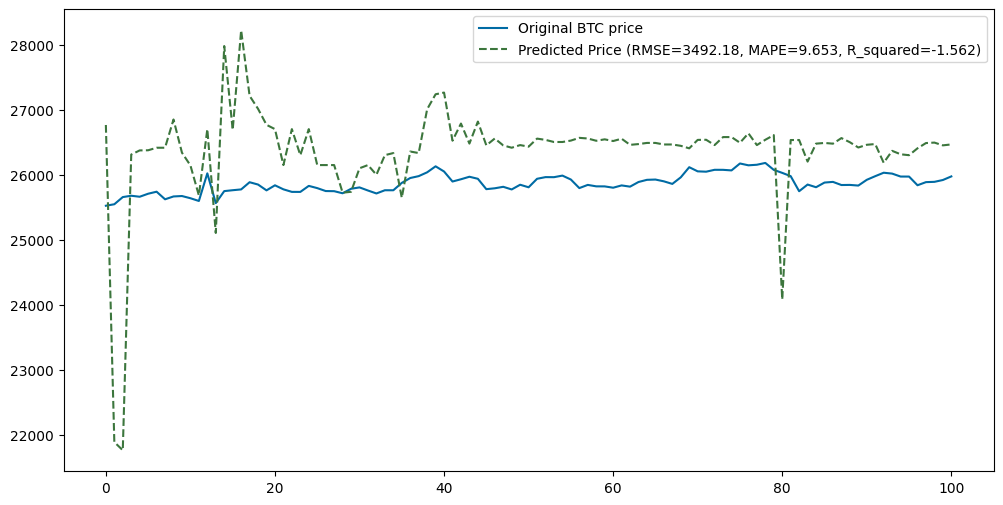

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### Decision Trees

In [45]:
from sklearn.tree import DecisionTreeRegressor

def dt_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = DecisionTreeRegressor()
    DT_mae, DT_r2 = run_model(model, n_folds, x_set, y_set)
    return round(DT_mae , 5), round(DT_r2, 5)

In [66]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 26):
    DT_mae, DT_r2 = dt_lag_search(scaled_train, i)
    error_list.append(DT_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(DT_mae) + " & R^2 : " + str(DT_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
dt_best_lag = lag_list[ind]
print("==========DT results==========")
print("Best lag: ", str(dt_best_lag))

Lag:  1  Error : -0.03191 & R^2 : 0.55825
Lag:  2  Error : -0.03237 & R^2 : 0.57215
Lag:  3  Error : -0.02905 & R^2 : 0.59003
Lag:  4  Error : -0.02943 & R^2 : 0.61868
Lag:  5  Error : -0.02853 & R^2 : 0.60183
Lag:  6  Error : -0.02777 & R^2 : 0.62374
Lag:  7  Error : -0.02873 & R^2 : 0.61699
Lag:  8  Error : -0.02827 & R^2 : 0.60525
Lag:  9  Error : -0.03409 & R^2 : 0.56047
Lag:  10  Error : -0.02891 & R^2 : 0.6313
Lag:  11  Error : -0.0343 & R^2 : 0.57775
Lag:  12  Error : -0.02897 & R^2 : 0.63554
Lag:  13  Error : -0.03485 & R^2 : 0.57442
Lag:  14  Error : -0.03484 & R^2 : 0.53023
Lag:  15  Error : -0.03334 & R^2 : 0.56273
Lag:  16  Error : -0.03007 & R^2 : 0.58369
Lag:  17  Error : -0.03433 & R^2 : 0.55594
Lag:  18  Error : -0.03376 & R^2 : 0.53991
Lag:  19  Error : -0.0339 & R^2 : 0.59385
Lag:  20  Error : -0.03328 & R^2 : 0.58817
Lag:  21  Error : -0.02955 & R^2 : 0.61089
Lag:  22  Error : -0.02873 & R^2 : 0.62617
Lag:  23  Error : -0.0278 & R^2 : 0.6508
Lag:  24  Error : -0.0274

In [67]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 24)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 24)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"max_depth":range(2, 31)}

# Create an object of SVR
dt_model = DecisionTreeRegressor(random_state = 2)

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
DT_grid = GridSearchCV(dt_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
DT_grid.fit(x_train, y_train)

# Store best parameters in variables
best_depth = DT_grid.best_params_['max_depth']

In [68]:
best_depth

26

In [46]:
best_depth = 26

In [47]:
# Use the above defined variables to create KNN object
model = DecisionTreeRegressor(max_depth = best_depth, random_state = 2)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [48]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

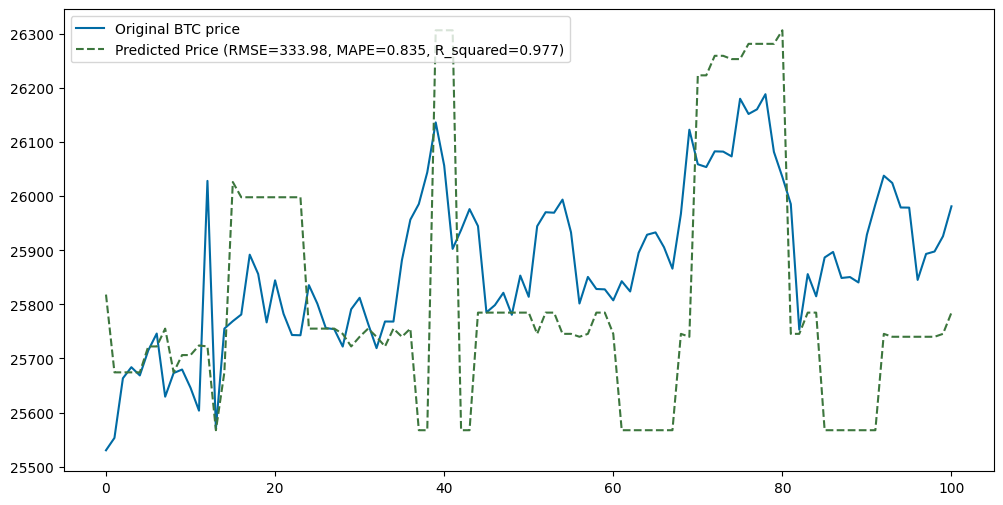

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

def rf_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = RandomForestRegressor()
    rf_mae, rf_r2 = run_model(model, n_folds, x_set, y_set)
    return round(rf_mae , 5), round(rf_r2, 5)

In [73]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 26):
    rf_mae, rf_r2 = rf_lag_search(scaled_train, i)
    error_list.append(rf_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(rf_mae) + " & R^2 : " + str(rf_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
rf_best_lag = lag_list[ind]
print("==========RF results==========")
print("Best lag: ", str(rf_best_lag))

Lag:  1  Error : -0.02774 & R^2 : 0.6841
Lag:  2  Error : -0.02864 & R^2 : 0.66674
Lag:  3  Error : -0.02874 & R^2 : 0.66086
Lag:  4  Error : -0.02911 & R^2 : 0.65765
Lag:  5  Error : -0.0285 & R^2 : 0.66806
Lag:  6  Error : -0.02852 & R^2 : 0.67443
Lag:  7  Error : -0.02886 & R^2 : 0.67489
Lag:  8  Error : -0.02888 & R^2 : 0.66896
Lag:  9  Error : -0.02906 & R^2 : 0.66587
Lag:  10  Error : -0.02897 & R^2 : 0.66936
Lag:  11  Error : -0.02966 & R^2 : 0.65479
Lag:  12  Error : -0.02944 & R^2 : 0.66132


KeyboardInterrupt: 

In [74]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"max_depth":range(2, 21), "n_estimators":range(2, 21)}

# Create an object of SVR
RF_model = RandomForestRegressor(random_state = 2)

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
RF_grid = GridSearchCV(RF_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
RF_grid.fit(x_train, y_train)

# Store best parameters in variables
RF_depth = RF_grid.best_params_['max_depth']
RF_estimators = RF_grid.best_params_['n_estimators']

KeyboardInterrupt: 

In [50]:
RF_depth, RF_estimators

(9, 2)

In [51]:
RF_depth = 9
RF_estimators = 2

In [54]:
model = RandomForestRegressor(max_depth = RF_depth, n_estimators = RF_estimators, random_state = 2)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [55]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

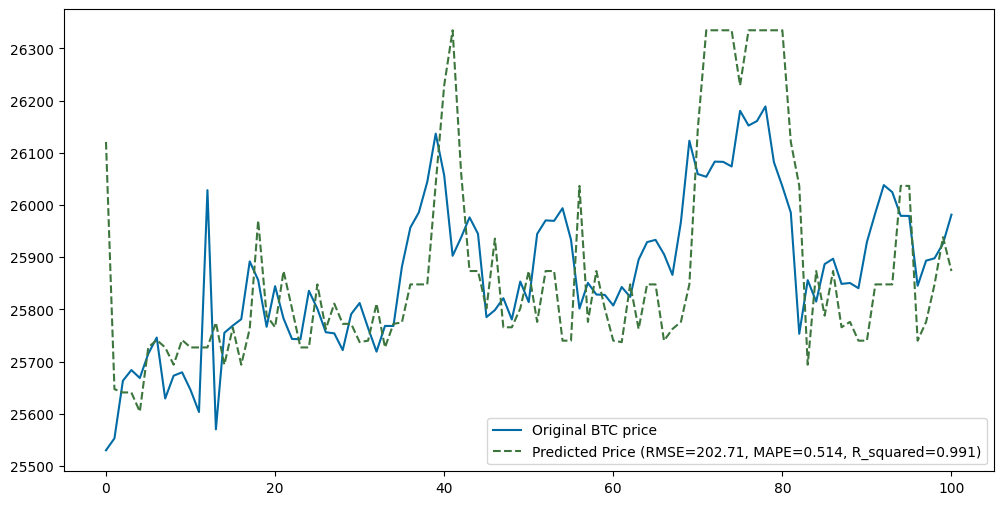

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### Gradient Boost

In [57]:
from sklearn.ensemble import GradientBoostingRegressor

def gb_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = GradientBoostingRegressor()
    gb_mae, gb_r2 = run_model(model, n_folds, x_set, y_set)
    return round(gb_mae , 5), round(gb_r2, 5)

In [80]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 15):
    gb_mae, gb_r2 = gb_lag_search(scaled_train, i)
    error_list.append(gb_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(gb_mae) + " & R^2 : " + str(gb_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
gb_best_lag = lag_list[ind]
print("==========GB results==========")
print("Best lag: ", str(gb_best_lag))

Lag:  1  Error : -0.02894 & R^2 : 0.66643
Lag:  2  Error : -0.03106 & R^2 : 0.63122
Lag:  3  Error : -0.02977 & R^2 : 0.64986
Lag:  4  Error : -0.02959 & R^2 : 0.65082
Lag:  5  Error : -0.0306 & R^2 : 0.65676
Lag:  6  Error : -0.03033 & R^2 : 0.66262
Lag:  7  Error : -0.03098 & R^2 : 0.63732
Lag:  8  Error : -0.0312 & R^2 : 0.63967
Lag:  9  Error : -0.03078 & R^2 : 0.6457
Lag:  10  Error : -0.03072 & R^2 : 0.65158
Lag:  11  Error : -0.03173 & R^2 : 0.65251
Lag:  12  Error : -0.03109 & R^2 : 0.65782
Lag:  13  Error : -0.03089 & R^2 : 0.66236


KeyboardInterrupt: 

In [82]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"n_estimators":range(2, 21), "learning_rate":np.linspace(0.1, 2, num = 5)}

# Create an object of SVR
GB_model = GradientBoostingRegressor(random_state = 2)

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
GB_grid = GridSearchCV(GB_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
GB_grid.fit(x_train, y_train)

# Store best parameters in variables
GB_estimators = GB_grid.best_params_['n_estimators']
GB_learning_rate = GB_grid.best_params_['learning_rate']

In [83]:
GB_estimators, GB_learning_rate

(6, 1.525)

In [58]:
GB_estimators = 6
GB_learning_rate = 1.525

In [59]:
model = GradientBoostingRegressor(n_estimators = GB_estimators, learning_rate = GB_learning_rate, random_state = 2)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [60]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

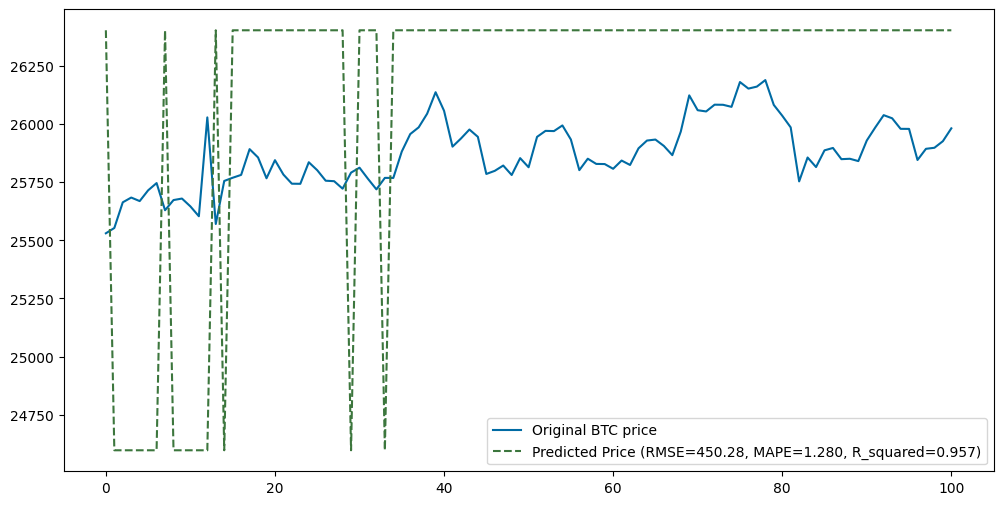

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### XGBoost

In [62]:
from xgboost import XGBRegressor

def xgb_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    model = XGBRegressor()
    xgb_mae, xgb_r2 = run_model(model, n_folds, x_set, y_set)
    return round(xgb_mae , 5), round(xgb_r2, 5)

In [87]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 21):
    xgb_mae, xgb_r2 = xgb_lag_search(scaled_train, i)
    error_list.append(xgb_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(xgb_mae) + " & R^2 : " + str(xgb_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
xgb_best_lag = lag_list[ind]
print("==========XGB results==========")
print("Best lag: ", str(xgb_best_lag))

Lag:  1  Error : -0.03803 & R^2 : 0.58304
Lag:  2  Error : -0.03998 & R^2 : 0.5658
Lag:  3  Error : -0.03435 & R^2 : 0.60642
Lag:  4  Error : -0.03706 & R^2 : 0.57737
Lag:  5  Error : -0.03133 & R^2 : 0.66057
Lag:  6  Error : -0.03182 & R^2 : 0.67813
Lag:  7  Error : -0.0343 & R^2 : 0.65495
Lag:  8  Error : -0.03516 & R^2 : 0.63673
Lag:  9  Error : -0.03553 & R^2 : 0.62648
Lag:  10  Error : -0.03515 & R^2 : 0.63816
Lag:  11  Error : -0.03485 & R^2 : 0.62461
Lag:  12  Error : -0.03337 & R^2 : 0.63883
Lag:  13  Error : -0.03248 & R^2 : 0.64937
Lag:  14  Error : -0.03363 & R^2 : 0.64645
Lag:  15  Error : -0.03356 & R^2 : 0.64629
Lag:  16  Error : -0.03145 & R^2 : 0.64556
Lag:  17  Error : -0.0372 & R^2 : 0.56251
Lag:  18  Error : -0.03761 & R^2 : 0.55117
Lag:  19  Error : -0.03811 & R^2 : 0.52267
Lag:  20  Error : -0.0383 & R^2 : 0.51249
==========XGB results==========
Best lag:  5


In [88]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 5)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 5)

# Create a dictionary of parameters from which best parameters are to be selected
params = {"n_estimators":range(2, 51)}

# Create an object of SVR
XGB_model = XGBRegressor(random_state = 2)

# Create a Gridsearch object with SVM model and above defined parameters with cross validation
XGB_grid = GridSearchCV(XGB_model, param_grid = params, cv = ts_folds)

# Fit the gridsearch object on feature variables and target column
XGB_grid.fit(x_train, y_train)

# Store best parameters in variables
XGB_estimators = XGB_grid.best_params_['n_estimators']

In [89]:
XGB_estimators

12

In [63]:
XGB_estimators = 12

In [64]:
model = XGBRegressor(n_estimators = XGB_estimators, random_state = 2)
model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [65]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

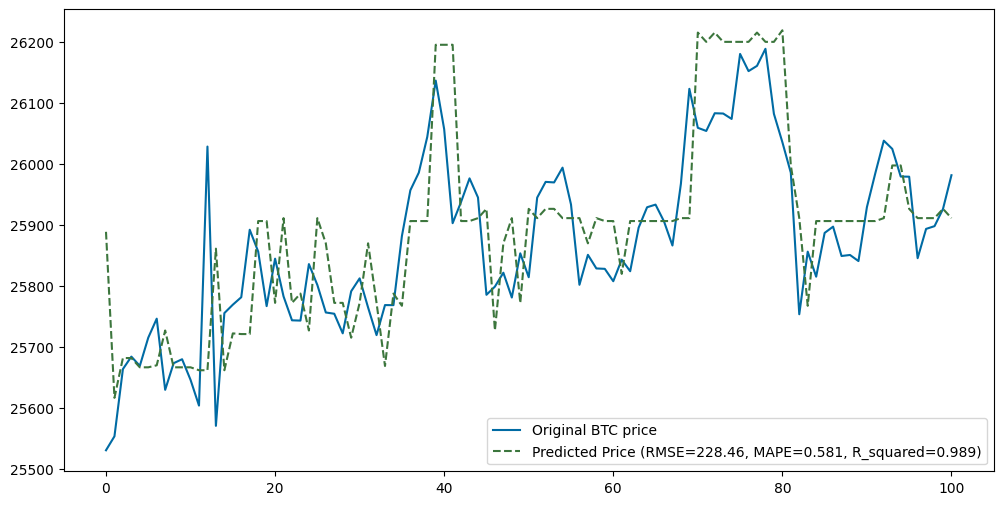

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### Ensembled voting regressor

In [67]:
from sklearn.ensemble import VotingRegressor

def v_lag_search(data, lags):
    x_set, y_set = lag_generator_1d_1output(data, windows = lags)
    XGB_model = XGBRegressor(n_estimators = XGB_estimators, random_state = 2)
    GB_model = GradientBoostingRegressor(n_estimators = GB_estimators, learning_rate = GB_learning_rate, random_state = 2)
    RF_model = RandomForestRegressor(max_depth = RF_depth, n_estimators = RF_estimators, random_state = 2)
    DT_model = DecisionTreeRegressor(max_depth = best_depth, random_state = 2)
    SVR_model = SVR(C = best_c, epsilon = best_epsilon)
    LR_model = Ridge()
    model = VotingRegressor([('XGB', XGB_model), ('GB', GB_model), ('RF', RF_model), ('DT', DT_model),
                             ('SVR', SVR_model), ('LR', LR_model)])
    v_mae, v_r2 = run_model(model, n_folds, x_set, y_set)
    return round(v_mae , 5), round(v_r2, 5)

In [93]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 15):
    v_mae, v_r2 = v_lag_search(scaled_train, i)
    error_list.append(v_mae)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(v_mae) + " & R^2 : " + str(v_r2))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
v_best_lag = lag_list[ind]
print("==========Voting results==========")
print("Best lag: ", str(v_best_lag))

KeyboardInterrupt: 

In [68]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

XGB_model = XGBRegressor(n_estimators = XGB_estimators, random_state = 2)
GB_model = GradientBoostingRegressor(n_estimators = GB_estimators, learning_rate = GB_learning_rate, random_state = 2)
RF_model = RandomForestRegressor(max_depth = RF_depth, n_estimators = RF_estimators, random_state = 2)
DT_model = DecisionTreeRegressor(max_depth = best_depth, random_state = 2)
SVR_model = SVR(C = best_c, epsilon = best_epsilon)
LR_model = Ridge()
model = VotingRegressor([('XGB', XGB_model), ('GB', GB_model), ('RF', RF_model), ('DT', DT_model),
                         ('SVR', SVR_model), ('LR', LR_model)])

model.fit(x_train, y_train)
pred = model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

In [69]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

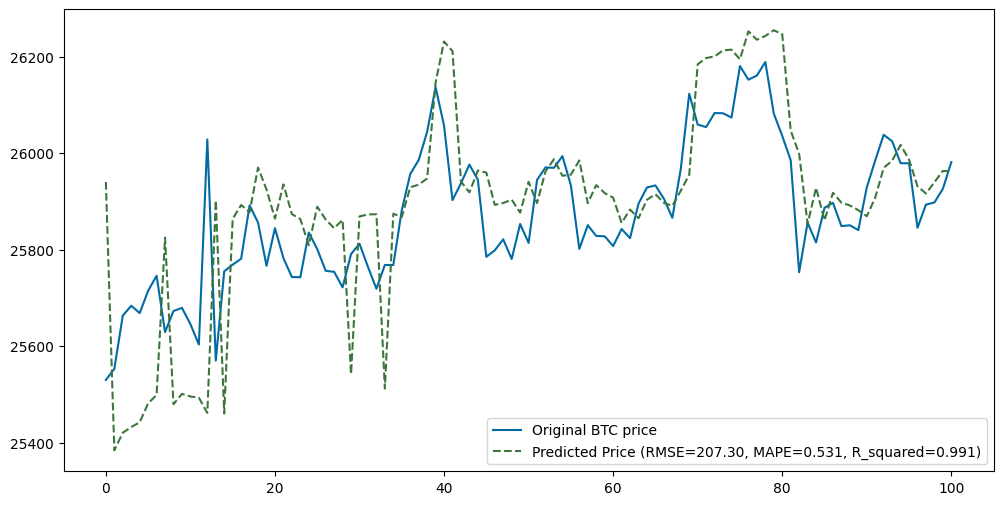

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

## Deep Learning

### ANN

In [71]:
tscv = TimeSeriesSplit(n_splits = 5)

In [110]:
len(x_test)

850

In [252]:
#Univariate
import random
def ANN_lag_search(data, lag):
    random.seed(2)
    with tf.device('/cpu:0'):
        x_set, y_set = lag_generator_1d_1output(data, windows = lag)
        input_train, output_train = x_set[0:len(x_set)-788], y_set[0:len(x_set)-788]
        input_test, output_test = x_set[len(x_set)-788:], y_set[len(x_set)-788:]
        
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(input_train[0].shape[0], input_dim = input_train[0].shape[0], activation = 'relu'))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = Adam(), loss = 'mse')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
    REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 2,
                                            factor = 0.25,
                                            min_lr = 1e-6,
                                            verbose = 0)

    # Train the model
    grid_model.fit(input_train, output_train, epochs = 100, batch_size = 8, validation_split = 0.2, shuffle = False,
                   callbacks = [callback, REDUCE_LR], verbose = 0)
    pred = grid_model.predict(input_test)

    pred = pred.reshape(-1, 1)
    pred = universal_y_enc.inverse_transform(pred)

    return rmse(output_test, pred)

In [253]:
# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 121):
    ANN_error = ANN_lag_search(scaled_train, i)
    error_list.append(ANN_error)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(ANN_error))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
ANN_best_lag = lag_list[ind]
print("==========ANN results==========")
print("Best lag: ", str(ANN_best_lag))

Epoch 36: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  1  Error : 27826.2103624438
Epoch 22: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  2  Error : 27791.944422479468
Epoch 24: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  3  Error : 27859.241671784228
Epoch 30: early stopping
25/25 [==============================] - 0s 2ms/step
Lag:  4  Error : 27632.749700363504
Epoch 9: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  5  Error : 28361.389108679625
Epoch 37: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  6  Error : 27941.598070138323
Epoch 30: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  7  Error : 27622.955747872875
Epoch 15: early stopping
25/25 [==============================] - 0s 2ms/step
Lag:  8  Error : 27363.367538796658
Epoch 26: early stopping
25/25 [==============================] - 0s 1ms/step
Lag:  9  Erro

Epoch 8: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  73  Error : 46409.07294080485
Epoch 9: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  74  Error : 55014.31110435818
Epoch 9: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  75  Error : 21389.553577182432
Epoch 8: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  76  Error : 42458.48877825812
Epoch 11: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  77  Error : 18539.971323967762
Epoch 8: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  78  Error : 42203.6397790552
Epoch 14: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  79  Error : 30918.658143823875
Epoch 7: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  80  Error : 15185.67929728961
Epoch 5: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  81  Error

In [32]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

In [33]:
x_train.shape, y_train.shape

((8259, 43), (8259, 1))

##### Batch size tuning

In [271]:
# Write a function to build ANN architecture during grid search

def model_arch():
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(x_train[0].shape[0], input_dim = x_train[0].shape[0], activation = 'relu'))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = Adam(), loss = 'mse')
        
        # Return built model
        return grid_model

In [272]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of acceptable batch size to search through for tuning
batch_size = [8, 16, 32, 64, 128]
# Create a dictionary with parameter name as key and list of values for the key
params = {'batch_size': batch_size}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 33: early stopping
Epoch 13: early stopping
Epoch 12: early stopping
Epoch 17: early stopping
Epoch 15: early stopping
Epoch 19: early stopping
Epoch 12: early stopping
Epoch 18: early stopping
Epoch 20: early stopping
Epoch 14: early stopping
Epoch 26: early stopping
Epoch 13: early stopping
Epoch 13: early stopping
Epoch 20: early stopping
Epoch 13: early stopping
Epoch 26: early stopping
Epoch 25: early stopping
Epoch 25: early stopping
Epoch 15: early stopping
Epoch 19: early stopping
Epoch 10: early stopping
Epoch 28: early stopping
Epoch 21: early stopping
Epoch 18: early stopping
Epoch 35: early stopping
Epoch 18: early stopping
4.690492167767175 {'batch_size': 64}


##### Activation function and optimizer tuning:

In [273]:
# Write a function to build ANN architecture during grid search

def model_arch(hidden_activation = 'relu', output_activation = 'linear', optimizer = Adam()):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(x_train[0].shape[0], input_dim = x_train[0].shape[0], activation = hidden_activation))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = optimizer, loss = 'mse')
        
        # Return built model
        return grid_model

In [274]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100, batch_size = 64,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of acceptable optimizer and activation functions to search through for tuning
optimizer = ['SGD', 'RMSprop','Adam']
hidden_activation = ['relu', 'linear', 'tanh', 'sigmoid']
output_activation = ['sigmoid', 'linear']

# Create a dictionary with parameter name as key and list of values for the key
params = {'model__optimizer': optimizer, 'model__hidden_activation':hidden_activation,
          'model__output_activation':output_activation}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 22: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 14: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 21: early stopping
Epoch 13: early stopping
Epoch 19: early stopping
Epoch 12: early stopping
Epoch 16: early stopping
Epoch 18: early stopping
Epoch 14: early stopping
Epoch 19: early stopping
Epoch 17: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 19: early stopping
Epoch 16: early stopping
Epoch 18: early stopping
Epoch 23: early stopping
Epoch 14: early stopping
Epoch 10: early stopping
Epoch 18: early stopping
Epoch 14: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 4: early stopping
Epoch 37: early stopping
Epoch 8: early sto

##### Learning rate and momentum tuning

In [277]:
# Write a function to build ANN architecture during grid search

def model_arch(learning_rate = 0.01, momentum = 0.1):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(x_train[0].shape[0], input_dim = x_train[0].shape[0], activation = 'linear'))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = RMSprop(learning_rate = learning_rate, momentum = momentum), loss = 'mse')
        
        # Return built model
        return grid_model

In [278]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100, batch_size = 64,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of learning_rate and momentum to search through for tuning
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.05, 0.01, 0.1]
momentum = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9]

# Create a dictionary with parameter name as key and list of values for the key
params = {'model__learning_rate': learning_rate, 'model__momentum': momentum}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 6: early stopping
Epoch 8: early stopping
Epoch 9: early stopping
Epoch 6: early stopping
Epoch 14: early stopping
Epoch 13: early stopping
Epoch 12: early stopping
Epoch 11: early stopping
Epoch 9: early stopping
Epoch 8: early stopping
Epoch 19: early stopping
Epoch 19: early stopping
Epoch 12: early stopping
Epoch 7: early stopping
Epoch 10: early stopping
Epoch 13: early stopping
Epoch 10: early stopping
Epoch 9: early stopping
Epoch 8: early stopping
Epoch 14: early stopping
Epoch 29: early stopping
Epoch 11: early stopping
Epoch 8: early stopping
Epoch 15: early stopping
Epoch 14: early stopping
Epoch 9: early stopping
Epoch 6: early stopping
Epoch 5: early stopping
Epoch 14: early stopping
Epoch 9: early stopping
Epoch 5: early stopping
Epoch 5: early stopping
Epoch 13: early stopping
Epoch 20: early stopping
Epoch 6: early stopping
Epoch 9: early stopping
Epoch 5: early stopping
Epoch 5: early stopping
Epoch 5: early stopping
Epoch 17: early stopping
Epoch 13: early stopp

##### Tuning number of neurons

In [280]:
# Write a function to build ANN architecture during grid search

def model_arch(neurons = 21):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(units = neurons, input_dim = x_train[0].shape[0], activation = 'linear'))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = RMSprop(learning_rate = 0.0001, momentum = 0.2), loss = 'mse')
        
        # Return built model
        return grid_model

In [281]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100, batch_size = 64,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of number of neurons to search through for tuning
neurons = [52, 108, 160, 216, 324, 432]

# Create a dictionary with parameter name as key and list of values for the key
params = {'model__neurons': neurons}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 20: early stopping
Epoch 17: early stopping
Epoch 6: early stopping
Epoch 7: early stopping
Epoch 12: early stopping
Epoch 20: early stopping
Epoch 53: early stopping
Epoch 10: early stopping
Epoch 8: early stopping
Epoch 17: early stopping
Epoch 60: early stopping
Epoch 37: early stopping
Epoch 11: early stopping
Epoch 7: early stopping
Epoch 15: early stopping
Epoch 13: early stopping
Epoch 65: early stopping
Epoch 31: early stopping
Epoch 8: early stopping
Epoch 17: early stopping
Epoch 12: early stopping
Epoch 19: early stopping
Epoch 9: early stopping
Epoch 5: early stopping
Epoch 14: early stopping
Epoch 11: early stopping
Epoch 6: early stopping
Epoch 9: early stopping
Epoch 6: early stopping
1.4973826107106307 {'model__neurons': 216}


##### Tuning regularization

In [282]:
# Write a function to build ANN architecture during grid search

def model_arch(l2 = 0.1):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(units = 216, input_dim = x_train[0].shape[0], activation = 'linear',
                             activity_regularizer = tf.keras.regularizers.L2(l2 = l2)))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = RMSprop(learning_rate = 0.0001, momentum = 0.2), loss = 'mse')
        
        # Return built model
        return grid_model

In [283]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100, batch_size = 64,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of penalty rate to search through for tuning
l2_rate = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Create a dictionary with parameter name as key and list of values for the key
params = {'model__l2': l2_rate}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 19: early stopping
Epoch 63: early stopping
Epoch 33: early stopping
Epoch 25: early stopping
Epoch 9: early stopping
Epoch 55: early stopping
Epoch 42: early stopping
Epoch 65: early stopping
Epoch 39: early stopping
Epoch 82: early stopping
Epoch 40: early stopping
Epoch 72: early stopping
Epoch 40: early stopping
Epoch 72: early stopping
Epoch 44: early stopping
Epoch 89: early stopping
Epoch 40: early stopping
Epoch 68: early stopping
Epoch 52: early stopping
Epoch 7: early stopping
1.5048713295525928 {'model__l2': 0}


##### Tuning dropout layers

In [287]:
# Write a function to build ANN architecture during grid search

def model_arch(rate = 0.1):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(Dense(units = 216, input_dim = x_train[0].shape[0], activation = 'linear',
                             activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
        grid_model.add(Dropout(rate = rate))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = RMSprop(learning_rate = 0.0001, momentum = 0.2), loss = 'mse')
        
        # Return built model
        return grid_model

In [288]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 0, epochs = 100, batch_size = 64,
                            callbacks = [callback, REDUCE_LR], validation_split = 0.2)

# Define a list of dropout rate to search through for tuning
drop = [0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

# Create a dictionary with parameter name as key and list of values for the key
params = {'model__rate': drop}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(estimator = grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 9: early stopping
Epoch 18: early stopping
Epoch 93: early stopping
Epoch 15: early stopping
Epoch 7: early stopping
Epoch 19: early stopping
Epoch 17: early stopping
Epoch 35: early stopping
Epoch 6: early stopping
Epoch 8: early stopping
Epoch 16: early stopping
Epoch 60: early stopping
Epoch 11: early stopping
Epoch 5: early stopping
Epoch 8: early stopping
Epoch 9: early stopping
Epoch 17: early stopping
Epoch 9: early stopping
Epoch 16: early stopping
Epoch 8: early stopping
Epoch 11: early stopping
Epoch 18: early stopping
Epoch 10: early stopping
Epoch 5: early stopping
Epoch 11: early stopping
Epoch 19: early stopping
Epoch 15: early stopping
Epoch 20: early stopping
Epoch 5: early stopping
Epoch 11: early stopping
Epoch 11: early stopping
Epoch 16: early stopping
Epoch 7: early stopping
Epoch 18: early stopping
Epoch 8: early stopping
Epoch 10: early stopping
Epoch 17: early stopping
Epoch 8: early stopping
Epoch 12: early stopping
Epoch 10: early stopping
Epoch 13: earl

##### Tuned model

In [76]:
with tf.device('/cpu:0'):
    # Create sequential model from tensorflow.keras
    ANN_model = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    ANN_model.add(Dense(units = x_train[0].shape[0], input_dim = x_train[0].shape[0], activation = 'relu',
                         activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    ANN_model.add(Dropout(rate = 0.01))

    # Add output layer with one 1 ouput neuron as this is regression problem
    ANN_model.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    ANN_model.compile(optimizer = Adam(), loss = 'mse')

In [77]:
# Define early stopping and learning rate reduction criteria
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Train the model
history = ANN_model.fit(x_train, y_train, epochs = 500, batch_size = 32, validation_split = 0.2, shuffle = True,
                        callbacks = [callback, REDUCE_LR])

Epoch 1/500
207/207 [==============================] - 1s 4ms/step - loss: 1.5692 - val_loss: 0.1194 - lr: 0.0010
Epoch 2/500
207/207 [==============================] - 1s 4ms/step - loss: 0.1916 - val_loss: 0.0826 - lr: 0.0010
Epoch 3/500
207/207 [==============================] - 1s 4ms/step - loss: 0.1247 - val_loss: 0.1041 - lr: 0.0010
Epoch 4/500
207/207 [==============================] - 1s 4ms/step - loss: 0.1108 - val_loss: 0.0549 - lr: 0.0010
Epoch 5/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0881 - val_loss: 0.0432 - lr: 0.0010
Epoch 6/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0892 - val_loss: 0.0382 - lr: 0.0010
Epoch 7/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0891 - val_loss: 0.0367 - lr: 0.0010
Epoch 8/500
207/207 [==============================] - 1s 4ms/step - loss: 0.1415 - val_loss: 0.0885 - lr: 0.0010
Epoch 9/500
207/207 [==============================] - 1s 4ms/step - loss: 0.0735 - val_

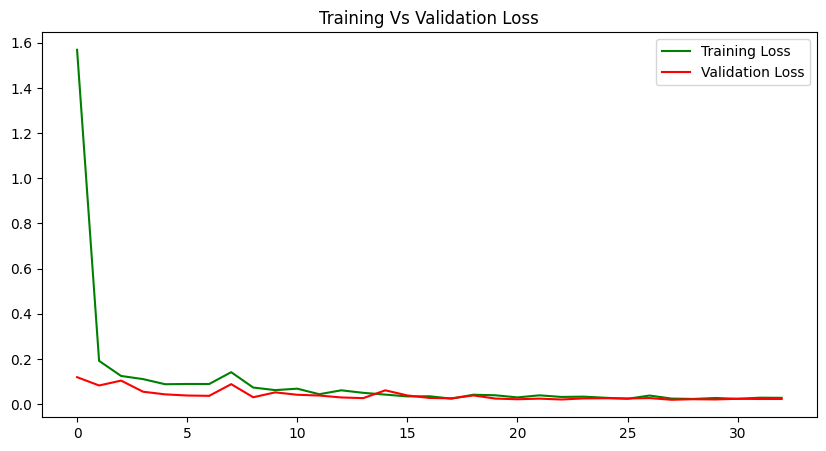

In [78]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_acc, color = 'green', label = 'Training Loss')
plt.plot(val_acc, color = 'red', label = 'Validation Loss')
plt.title('Training Vs Validation Loss')
plt.legend()

In [79]:
pred = ANN_model.predict(x_test)

pred = pred.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(y_test)

16/16 [==============================] - 0s 1ms/step


In [80]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

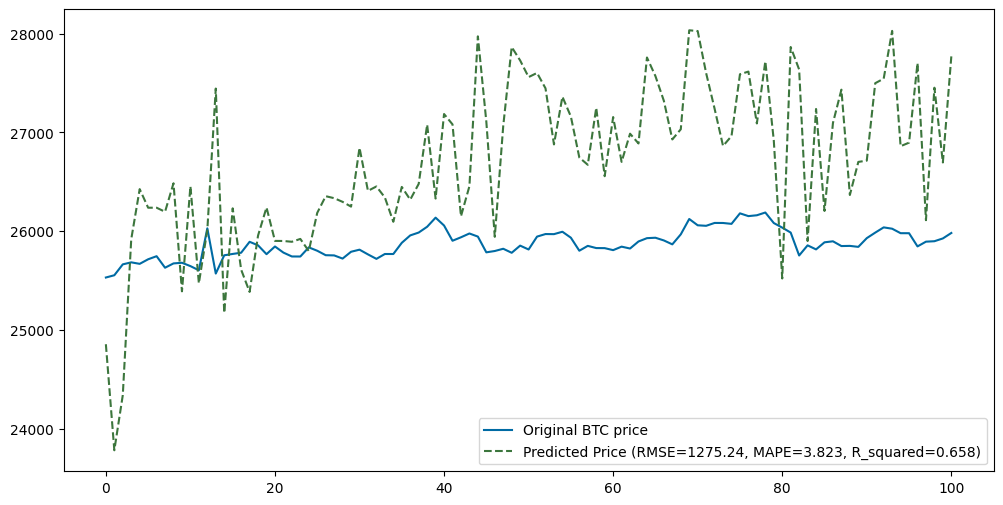

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### LSTM

In [84]:
#Univariate
import random
def LSTM_lag_search(data, lag):
    random.seed(2)
    with tf.device('/cpu:0'):
        x_set, y_set = lag_generator_1out(data, windows = lag)
        input_train, output_train = x_set[0:len(x_set)-800], y_set[0:len(x_set)-800]
        input_test, output_test = x_set[len(x_set)-800:], y_set[len(x_set)-800:]
        
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(input_train[0].shape[1], input_shape=input_train[0].shape,
                            activation = "tanh", recurrent_activation = "sigmoid"))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = Adam(), loss = 'mse')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
    REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 2,
                                            factor = 0.25,
                                            min_lr = 1e-6,
                                            verbose = 0)

    # Train the model
    grid_model.fit(input_train, output_train, epochs = 100, batch_size = 8, validation_split = 0.2, shuffle = False,
                   callbacks = [callback, REDUCE_LR], verbose = 0)
    pred = grid_model.predict(input_test)

    pred = pred.reshape(-1, 1)
    pred = universal_y_enc.inverse_transform(pred)

    return rmse(output_test, pred)

# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 121):
    LSTM_error = LSTM_lag_search(scaled_train, i)
    error_list.append(LSTM_error)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(LSTM_error))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
LSTM_best_lag = lag_list[ind]
print("==========LSTM results==========")
print("Best lag: ", str(LSTM_best_lag))

Epoch 10: early stopping
25/25 [==============================] - 0s 2ms/step
Lag:  1  Error : 26287.993591693456
Epoch 14: early stopping
25/25 [==============================] - 0s 2ms/step
Lag:  2  Error : 26677.072466976548


KeyboardInterrupt: 

In [36]:
x_train, y_train = lag_generator_1out(scaled_train, windows = 1)
x_test, y_test = lag_generator_1out(scaled_test, windows = 1)

##### Batch-size tuning

In [37]:
x_train.shape, y_train.shape

((8259, 43), (8259, 1))

In [332]:
# Write a function to build ANN architecture during grid search
def model_arch():
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True))
        grid_model.add(LSTM(19))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = Adam(), loss = 'mse')
        
        # Return built model
        return grid_model

In [333]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2)

# Define a list of acceptable batch size to search through for tuning
batch_size = [8, 16, 32, 64, 128]
# Create a dictionary with parameter name as key and list of values for the key
params = {'batch_size': batch_size}


# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
132/132 [==============================] - 5s 15ms/step - loss: 0.0757 - val_loss: 0.0425 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0240 - val_loss: 0.0215 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0120 - val_loss: 0.0199 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0106 - val_loss: 0.0176 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0148 - lr: 0.0010
Epoch 6/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0079 - val_loss: 0.0249 - lr: 0.0010
Epoch 7/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0079 - val_loss: 0.0131 - lr: 0.0010
Epoch 8/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0102 - lr: 0.0010
Epoch 9/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0072 - val_

Epoch 14/50
526/526 [==============================] - 5s 10ms/step - loss: 7.9607e-04 - val_loss: 7.0790e-04 - lr: 1.5625e-05
Epoch 15/50
526/526 [==============================] - 5s 9ms/step - loss: 7.9166e-04 - val_loss: 6.4215e-04 - lr: 1.5625e-05
Epoch 16/50
526/526 [==============================] - 5s 10ms/step - loss: 7.8088e-04 - val_loss: 6.5217e-04 - lr: 3.9063e-06
Epoch 17/50
526/526 [==============================] - 5s 10ms/step - loss: 7.7970e-04 - val_loss: 6.5397e-04 - lr: 3.9063e-06
Epoch 18/50
526/526 [==============================] - 5s 10ms/step - loss: 7.7579e-04 - val_loss: 6.6604e-04 - lr: 1.0000e-06
Epoch 19/50
526/526 [==============================] - 5s 9ms/step - loss: 7.7540e-04 - val_loss: 6.7174e-04 - lr: 1.0000e-06
Epoch 19: early stopping
165/165 [==============================] - 1s 4ms/step
Epoch 1/50
657/657 [==============================] - 8s 9ms/step - loss: 0.0470 - val_loss: 0.1752 - lr: 0.0010
Epoch 2/50
657/657 [===========================

Epoch 5/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.1807 - lr: 0.0010
Epoch 6/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.1542 - lr: 0.0010
Epoch 7/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0026 - val_loss: 0.1389 - lr: 0.0010
Epoch 8/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0024 - val_loss: 0.1503 - lr: 0.0010
Epoch 9/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0022 - val_loss: 0.1576 - lr: 0.0010
Epoch 10/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0015 - val_loss: 0.1455 - lr: 2.5000e-04
Epoch 11/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0014 - val_loss: 0.1409 - lr: 2.5000e-04
Epoch 11: early stopping
83/83 [==============================] - 1s 3ms/step
Epoch 1/50
263/263 [==============================] - 6s 12ms/step - loss: 0.0870 - val_loss: 0.0243 - lr: 0.0010
E

132/132 [==============================] - 1s 10ms/step - loss: 0.0024 - val_loss: 0.0015 - lr: 2.5000e-04
Epoch 8/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 0.0031 - lr: 2.5000e-04
Epoch 9/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0017 - lr: 2.5000e-04
Epoch 10/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0014 - lr: 6.2500e-05
Epoch 11/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0014 - lr: 6.2500e-05
Epoch 12/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0014 - lr: 6.2500e-05
Epoch 13/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0014 - lr: 6.2500e-05
Epoch 14/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0015 - lr: 1.5625e-05
Epoch 15/50
132/132 [==============================] - 1s 9ms/

9/9 [==============================] - 0s 16ms/step - loss: 0.0893 - val_loss: 0.0871 - lr: 2.5000e-04
Epoch 6/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0886 - val_loss: 0.0861 - lr: 2.5000e-04
Epoch 6: early stopping
11/11 [==============================] - 1s 6ms/step
Epoch 1/50
17/17 [==============================] - 3s 56ms/step - loss: 0.1193 - val_loss: 0.1456 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 0s 16ms/step - loss: 0.1050 - val_loss: 0.0908 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0978 - val_loss: 0.0960 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0849 - val_loss: 0.0869 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 0s 12ms/step - loss: 0.0607 - val_loss: 0.0368 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0379 - lr: 0.0010
Epoch 7/50
17/17 [================

##### Optimizer tuning

In [337]:
# Write a function to build ANN architecture during grid search
def model_arch(optimizer = Adam()):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True))
        grid_model.add(LSTM(19))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = optimizer, loss = 'mse')
        
        # Return built model
        return grid_model

In [338]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16)

# Define a list of acceptable optimizer and activation functions to search through for tuning
optimizer = ['SGD', 'RMSprop','Adam']

# Create a dictionary with parameter name as key and list of values for the key
params = {'optimizer': optimizer}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
33/33 [==============================] - 3s 29ms/step - loss: 0.1011 - val_loss: 0.0814 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0817 - val_loss: 0.0667 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0495 - val_loss: 0.0382 - lr: 0.0010
Epoch 4/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0250 - val_loss: 0.0265 - lr: 0.0010
Epoch 5/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.0195 - lr: 0.0010
Epoch 6/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0126 - val_loss: 0.0175 - lr: 0.0010
Epoch 7/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0108 - val_loss: 0.0188 - lr: 0.0010
Epoch 8/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0177 - lr: 0.0010
Epoch 9/50
33/33 [==============================] - 0s 10ms/step - loss: 0.0086 - val_loss: 0.0159 - lr:

Epoch 38/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1085 - val_loss: 0.1401 - lr: 1.0000e-06
Epoch 39/50
66/66 [==============================] - 1s 11ms/step - loss: 0.1085 - val_loss: 0.1400 - lr: 1.0000e-06
Epoch 40/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1085 - val_loss: 0.1398 - lr: 1.0000e-06
Epoch 41/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1084 - val_loss: 0.1396 - lr: 1.0000e-06
Epoch 42/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1084 - val_loss: 0.1394 - lr: 1.0000e-06
Epoch 43/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1084 - val_loss: 0.1392 - lr: 1.0000e-06
Epoch 44/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1084 - val_loss: 0.1391 - lr: 1.0000e-06
Epoch 45/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1083 - val_loss: 0.1389 - lr: 1.0000e-06
Epoch 46/50
66/66 [==============================] - 1s 10ms/ste

33/33 [==============================] - 0s 10ms/step - loss: 0.1092 - val_loss: 0.1217 - lr: 1.0000e-06
Epoch 21/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1090 - val_loss: 0.1215 - lr: 1.0000e-06
Epoch 22/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1088 - val_loss: 0.1212 - lr: 1.0000e-06
Epoch 23/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1086 - val_loss: 0.1209 - lr: 1.0000e-06
Epoch 24/50
33/33 [==============================] - 0s 11ms/step - loss: 0.1084 - val_loss: 0.1207 - lr: 1.0000e-06
Epoch 25/50
33/33 [==============================] - 0s 12ms/step - loss: 0.1082 - val_loss: 0.1204 - lr: 1.0000e-06
Epoch 26/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1080 - val_loss: 0.1202 - lr: 1.0000e-06
Epoch 27/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1079 - val_loss: 0.1200 - lr: 1.0000e-06
Epoch 28/50
33/33 [==============================] - 0s 10ms/step - loss: 0.

165/165 [==============================] - 2s 10ms/step - loss: 0.3140 - val_loss: 0.5601 - lr: 1.0000e-06
Epoch 3/50
165/165 [==============================] - 2s 10ms/step - loss: 0.3107 - val_loss: 0.5615 - lr: 1.0000e-06
Epoch 4/50
165/165 [==============================] - 2s 10ms/step - loss: 0.3080 - val_loss: 0.5627 - lr: 1.0000e-06
Epoch 5/50
165/165 [==============================] - 2s 10ms/step - loss: 0.3056 - val_loss: 0.5638 - lr: 1.0000e-06
Epoch 5: early stopping
42/42 [==============================] - 1s 3ms/step
Epoch 1/50
33/33 [==============================] - 3s 31ms/step - loss: 0.1028 - val_loss: 0.1176 - lr: 1.0000e-06
Epoch 2/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1021 - val_loss: 0.1165 - lr: 1.0000e-06
Epoch 3/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1015 - val_loss: 0.1158 - lr: 1.0000e-06
Epoch 4/50
33/33 [==============================] - 0s 10ms/step - loss: 0.1011 - val_loss: 0.1151 - lr: 1.0000e-0

Epoch 36/50
99/99 [==============================] - 1s 9ms/step - loss: 0.1089 - val_loss: 0.7689 - lr: 1.0000e-06
Epoch 37/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1088 - val_loss: 0.7674 - lr: 1.0000e-06
Epoch 38/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1086 - val_loss: 0.7660 - lr: 1.0000e-06
Epoch 39/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1085 - val_loss: 0.7646 - lr: 1.0000e-06
Epoch 40/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1083 - val_loss: 0.7631 - lr: 1.0000e-06
Epoch 41/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1082 - val_loss: 0.7616 - lr: 1.0000e-06
Epoch 42/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1080 - val_loss: 0.7602 - lr: 1.0000e-06
Epoch 43/50
99/99 [==============================] - 1s 10ms/step - loss: 0.1079 - val_loss: 0.7587 - lr: 1.0000e-06
Epoch 44/50
99/99 [==============================] - 1s 10ms/step

##### Tuning learning rate

In [340]:
# Write a function to build ANN architecture during grid search
def model_arch(learning_rate = 0.01):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True))
        grid_model.add(LSTM(19))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = SGD(learning_rate = learning_rate), loss = 'mse')
        
        # Return built model
        return grid_model

In [343]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16, learning_rate = 0.0005)

# Define a list of learning_rate and momentum to search through for tuning
learning_rate = [0.0005, 0.001, 0.05, 0.1]

# Create a dictionary with parameter name as key and list of values for the key
params = {'learning_rate': learning_rate}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
66/66 [==============================] - 3s 19ms/step - loss: 0.1136 - val_loss: 0.1171 - lr: 5.0000e-04
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 0.1071 - val_loss: 0.1070 - lr: 5.0000e-04
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1031 - val_loss: 0.0999 - lr: 5.0000e-04
Epoch 4/50
66/66 [==============================] - 1s 9ms/step - loss: 0.1007 - val_loss: 0.0950 - lr: 5.0000e-04
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0992 - val_loss: 0.0915 - lr: 5.0000e-04
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0982 - val_loss: 0.0889 - lr: 5.0000e-04
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0976 - val_loss: 0.0871 - lr: 5.0000e-04
Epoch 8/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0971 - val_loss: 0.0857 - lr: 5.0000e-04
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0

Epoch 46/50
132/132 [==============================] - 1s 10ms/step - loss: 0.1065 - val_loss: 0.1119 - lr: 1.0000e-06
Epoch 47/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1065 - val_loss: 0.1119 - lr: 1.0000e-06
Epoch 48/50
132/132 [==============================] - 1s 10ms/step - loss: 0.1065 - val_loss: 0.1119 - lr: 1.0000e-06
Epoch 49/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1065 - val_loss: 0.1119 - lr: 1.0000e-06
Epoch 50/50
83/83 [==============================] - 1s 3ms/step
Epoch 1/50
198/198 [==============================] - 5s 12ms/step - loss: 0.1003 - val_loss: 0.6451 - lr: 5.0000e-04
Epoch 2/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0946 - val_loss: 0.5999 - lr: 5.0000e-04
Epoch 3/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0933 - val_loss: 0.5749 - lr: 5.0000e-04
Epoch 4/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0929 - val_loss: 0.5628 - lr: 5.

132/132 [==============================] - 1s 9ms/step - loss: 0.1112 - val_loss: 0.1363 - lr: 2.5000e-04
Epoch 12/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1112 - val_loss: 0.1358 - lr: 2.5000e-04
Epoch 13/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1111 - val_loss: 0.1357 - lr: 2.5000e-04
Epoch 14/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1110 - val_loss: 0.1352 - lr: 2.5000e-04
Epoch 15/50
132/132 [==============================] - 1s 10ms/step - loss: 0.1110 - val_loss: 0.1351 - lr: 2.5000e-04
Epoch 16/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1109 - val_loss: 0.1348 - lr: 2.5000e-04
Epoch 17/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1108 - val_loss: 0.1346 - lr: 2.5000e-04
Epoch 18/50
132/132 [==============================] - 1s 10ms/step - loss: 0.1107 - val_loss: 0.1342 - lr: 2.5000e-04
Epoch 19/50
132/132 [==============================] - 1s 9ms/step

Epoch 31/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0897 - val_loss: 0.4930 - lr: 1.5625e-05
Epoch 32/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0897 - val_loss: 0.4929 - lr: 1.5625e-05
Epoch 33/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 1.5625e-05
Epoch 34/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 1.5625e-05
Epoch 35/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 1.5625e-05
Epoch 36/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 3.9063e-06
Epoch 37/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 3.9063e-06
Epoch 38/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0897 - val_loss: 0.4928 - lr: 1.0000e-06
Epoch 39/50
198/198 [==============================]

329/329 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.0839 - lr: 0.0125
Epoch 16/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.0840 - lr: 0.0125
Epoch 17/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0809 - lr: 0.0031
Epoch 18/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0798 - lr: 0.0031
Epoch 19/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0785 - lr: 0.0031
Epoch 20/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.0788 - lr: 0.0031
Epoch 21/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.0788 - lr: 0.0031
Epoch 22/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.0775 - lr: 7.8125e-04
Epoch 23/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.

198/198 [==============================] - 2s 9ms/step - loss: 0.0841 - val_loss: 0.5323 - lr: 0.1000
Epoch 3/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0685 - val_loss: 0.5750 - lr: 0.1000
Epoch 4/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0516 - val_loss: 0.2067 - lr: 0.0250
Epoch 5/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0422 - val_loss: 0.1597 - lr: 0.0250
Epoch 6/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0335 - val_loss: 0.1829 - lr: 0.0250
Epoch 7/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.1250 - lr: 0.0250
Epoch 8/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0189 - val_loss: 0.0884 - lr: 0.0250
Epoch 9/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0143 - val_loss: 0.1100 - lr: 0.0250
Epoch 10/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0112 - val_loss: 0.1179 - lr:

##### Tuning number of neurons

In [344]:
# Write a function to build ANN architecture during grid search
def model_arch(neurons = 21):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(units = neurons, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True))
        grid_model.add(LSTM(units = neurons))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = SGD(learning_rate = 0.1), loss = 'mse')
        
        # Return built model
        return grid_model

In [345]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16, neurons = 19)

# Define a list of number of neurons to search through for tuning
neurons = [19, 38, 57, 76, 95, 114, 190]

# Create a dictionary with parameter name as key and list of values for the key
params = {'neurons': neurons}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
66/66 [==============================] - 3s 21ms/step - loss: 0.0946 - val_loss: 0.0917 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0899 - val_loss: 0.1088 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0904 - val_loss: 0.0843 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0796 - val_loss: 0.0636 - lr: 0.1000
Epoch 5/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0702 - val_loss: 0.0868 - lr: 0.1000
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0667 - val_loss: 0.0672 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0468 - val_loss: 0.0399 - lr: 0.0250
Epoch 8/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0411 - val_loss: 0.0375 - lr: 0.0250
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0353 - val_loss: 0.0338 - lr: 0.0

66/66 [==============================] - 1s 10ms/step - loss: 0.0062 - val_loss: 0.0122 - lr: 0.0250
Epoch 25/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 0.0113 - lr: 0.0250
Epoch 26/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0062 - val_loss: 0.0115 - lr: 0.0250
Epoch 27/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0146 - lr: 0.0250
Epoch 28/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0106 - lr: 0.0063
Epoch 29/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0104 - lr: 0.0063
Epoch 30/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0102 - lr: 0.0063
Epoch 31/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0102 - lr: 0.0063
Epoch 32/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.0099 - lr: 0.0

263/263 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0037 - lr: 0.0063
Epoch 12/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0030 - lr: 0.0063
Epoch 13/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0031 - lr: 0.0016
Epoch 14/50
263/263 [==============================] - 3s 9ms/step - loss: 0.0023 - val_loss: 0.0032 - lr: 0.0016
Epoch 15/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0031 - lr: 3.9063e-04
Epoch 16/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0023 - val_loss: 0.0031 - lr: 3.9063e-04
Epoch 16: early stopping
83/83 [==============================] - 1s 5ms/step
Epoch 1/50
329/329 [==============================] - 6s 11ms/step - loss: 0.1314 - val_loss: 0.4426 - lr: 0.1000
Epoch 2/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0474 - val_loss: 0.1800 - lr: 0.1000
Epoch 3/50
329/

329/329 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0745 - lr: 0.0250
Epoch 16/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 0.0851 - lr: 0.0250
Epoch 17/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 0.0779 - lr: 0.0063
Epoch 18/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 0.0769 - lr: 0.0063
Epoch 18: early stopping
83/83 [==============================] - 1s 5ms/step
Epoch 1/50
66/66 [==============================] - 4s 19ms/step - loss: 0.0985 - val_loss: 0.1063 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0935 - val_loss: 0.1017 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0912 - val_loss: 0.0784 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0850 - val_loss: 0.0653 - lr: 0.1000
Epoch 5/50
66/66 [==============

66/66 [==============================] - 1s 10ms/step - loss: 0.0128 - val_loss: 0.0226 - lr: 0.0063
Epoch 16: early stopping
83/83 [==============================] - 1s 4ms/step
Epoch 1/50
132/132 [==============================] - 4s 15ms/step - loss: 0.1110 - val_loss: 0.0839 - lr: 0.1000
Epoch 2/50
132/132 [==============================] - 1s 9ms/step - loss: 0.1046 - val_loss: 0.0670 - lr: 0.1000
Epoch 3/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0960 - val_loss: 0.0574 - lr: 0.1000
Epoch 4/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0825 - val_loss: 0.0757 - lr: 0.1000
Epoch 5/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0603 - val_loss: 0.0919 - lr: 0.1000
Epoch 6/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0326 - val_loss: 0.0373 - lr: 0.0250
Epoch 7/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0264 - val_loss: 0.0483 - lr: 0.0250
Epoch 8/50
132/132 [=======

329/329 [==============================] - 3s 9ms/step - loss: 0.0036 - val_loss: 0.0953 - lr: 0.0250
Epoch 8/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0033 - val_loss: 0.0957 - lr: 0.0250
Epoch 9/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0030 - val_loss: 0.0910 - lr: 0.0250
Epoch 10/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0028 - val_loss: 0.0876 - lr: 0.0250
Epoch 11/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0027 - val_loss: 0.0785 - lr: 0.0250
Epoch 12/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0026 - val_loss: 0.0898 - lr: 0.0250
Epoch 13/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 0.0744 - lr: 0.0250
Epoch 14/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0024 - val_loss: 0.0798 - lr: 0.0250
Epoch 15/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0022 - val_loss: 0.0791 -

##### Tuning weight initialisation

In [348]:
# Write a function to build ANN architecture during grid search
def model_arch(kernel_initializer = 'random_normal'):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(units = 19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True, 
                            kernel_initializer = kernel_initializer, bias_initializer = 'zeros'))
        grid_model.add(LSTM(units = 19, kernel_initializer = kernel_initializer, bias_initializer = 'zeros'))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = SGD(learning_rate = 0.1), loss = 'mse')
        
        # Return built model
        return grid_model

In [349]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16, kernel_initializer = 'glorot_normal')

# Define a list of number of neurons to search through for RandomForestRegressorForestRegressor
kernel = ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform', 'random_normal', 'random_uniform']

# Create a dictionary with parameter name as key and list of values for the key
params = {'kernel_initializer': kernel}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
66/66 [==============================] - 3s 18ms/step - loss: 0.0959 - val_loss: 0.1367 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0924 - val_loss: 0.1468 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0854 - val_loss: 0.0718 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0816 - val_loss: 0.0721 - lr: 0.1000
Epoch 5/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0763 - val_loss: 0.0652 - lr: 0.1000
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0703 - val_loss: 0.0577 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0602 - val_loss: 0.0909 - lr: 0.1000
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0527 - val_loss: 0.0421 - lr: 0.1000
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0421 - val_loss: 0.0847 - lr: 0.1

66/66 [==============================] - 1s 10ms/step - loss: 0.0267 - val_loss: 0.0304 - lr: 0.0063
Epoch 30/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0251 - val_loss: 0.0296 - lr: 0.0063
Epoch 31/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0243 - val_loss: 0.0279 - lr: 0.0063
Epoch 32/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0230 - val_loss: 0.0266 - lr: 0.0063
Epoch 33/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0216 - val_loss: 0.0254 - lr: 0.0063
Epoch 34/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0211 - val_loss: 0.0272 - lr: 0.0063
Epoch 35/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0203 - val_loss: 0.0240 - lr: 0.0063
Epoch 36/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0187 - val_loss: 0.0223 - lr: 0.0063
Epoch 37/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0184 - val_loss: 0.0293 - lr: 0.006

132/132 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.5259e-06
Epoch 28/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.5259e-06
Epoch 29/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 30/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 31/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 32/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 33/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 34/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0014 - lr: 1.0000e-06
Epoch 35/50
132/132 [==============================] - 1s 9ms/ste

Epoch 10/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0041 - lr: 0.1000
Epoch 11/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0037 - val_loss: 0.0040 - lr: 0.1000
Epoch 12/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0053 - lr: 0.1000
Epoch 13/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0039 - lr: 0.0250
Epoch 14/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0036 - lr: 0.0250
Epoch 15/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0041 - lr: 0.0250
Epoch 16/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.0036 - lr: 0.0250
Epoch 17/50
66/66 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0039 - lr: 0.0063
Epoch 18/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0039 -

Epoch 12: early stopping
83/83 [==============================] - 1s 4ms/step
Epoch 1/50
66/66 [==============================] - 3s 20ms/step - loss: 0.1030 - val_loss: 0.0966 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0994 - val_loss: 0.0833 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0952 - val_loss: 0.0855 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0920 - val_loss: 0.0716 - lr: 0.1000
Epoch 5/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0913 - val_loss: 0.0794 - lr: 0.1000
Epoch 6/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0888 - val_loss: 0.0686 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0865 - val_loss: 0.0852 - lr: 0.1000
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0809 - val_loss: 0.0808 - lr: 0.1000
Epoch 9/50
66/66 [===========

329/329 [==============================] - 3s 9ms/step - loss: 0.0020 - val_loss: 0.1038 - lr: 0.0250
Epoch 16/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0019 - val_loss: 0.1004 - lr: 0.0250
Epoch 17/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.1006 - lr: 0.0250
Epoch 18/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.1000 - lr: 0.0250
Epoch 19/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0904 - lr: 0.0250
Epoch 20/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0017 - val_loss: 0.0905 - lr: 0.0250
Epoch 21/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.0892 - lr: 0.0250
Epoch 22/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.0852 - lr: 0.0250
Epoch 23/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.0847

##### Tuning regularization

In [350]:
# Write a function to build ANN architecture during grid search
def model_arch(l2 = 0.1):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(units = 19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True, 
                            kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = l2)))
        grid_model.add(LSTM(units = 19, kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = l2)))
        
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = SGD(learning_rate = 0.1), loss = 'mse')
        
        # Return built model
        return grid_model

In [351]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16, l2 = 0.1)

# Define a list of penalty rate to search through for tuning
l2_rate = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Create a dictionary with parameter name as key and list of values for the key
params = {'l2': l2_rate}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
66/66 [==============================] - 3s 20ms/step - loss: 0.0565 - val_loss: 0.0349 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0178 - val_loss: 0.0206 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0071 - val_loss: 0.0113 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0044 - lr: 0.1000
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0052 - lr: 0.1000
Epoch 6/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0032 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0042 - lr: 0.1000
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0029 - lr: 0.1000
Epoch 9/50
66/66 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 0.0046 - lr:

132/132 [==============================] - 1s 10ms/step - loss: 0.0188 - val_loss: 0.0209 - lr: 0.0063
Epoch 35/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0187 - val_loss: 0.0208 - lr: 0.0063
Epoch 36/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0187 - val_loss: 0.0208 - lr: 0.0063
Epoch 37/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0186 - val_loss: 0.0206 - lr: 0.0063
Epoch 38/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0185 - val_loss: 0.0207 - lr: 0.0063
Epoch 39/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0184 - val_loss: 0.0204 - lr: 0.0063
Epoch 40/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0183 - val_loss: 0.0203 - lr: 0.0063
Epoch 41/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0183 - val_loss: 0.0202 - lr: 0.0063
Epoch 42/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0182 - val_los

132/132 [==============================] - 1s 10ms/step - loss: 0.0739 - val_loss: 0.0765 - lr: 0.1000
Epoch 7/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0662 - val_loss: 0.0662 - lr: 0.1000
Epoch 8/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0568 - val_loss: 0.0582 - lr: 0.1000
Epoch 9/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0521 - val_loss: 0.0525 - lr: 0.1000
Epoch 10/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0445 - val_loss: 0.0473 - lr: 0.1000
Epoch 11/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0433 - val_loss: 0.0465 - lr: 0.1000
Epoch 12/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0407 - val_loss: 0.0589 - lr: 0.1000
Epoch 13/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0366 - val_loss: 0.0669 - lr: 0.1000
Epoch 14/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0309 - val_loss: 0.

66/66 [==============================] - 1s 10ms/step - loss: 0.0524 - val_loss: 0.0499 - lr: 0.0250
Epoch 28/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0503 - val_loss: 0.0512 - lr: 0.0250
Epoch 29/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0504 - val_loss: 0.0481 - lr: 0.0250
Epoch 30/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0502 - val_loss: 0.0473 - lr: 0.0250
Epoch 31/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0498 - val_loss: 0.0465 - lr: 0.0250
Epoch 32/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0484 - val_loss: 0.0460 - lr: 0.0250
Epoch 33/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0473 - val_loss: 0.0450 - lr: 0.0250
Epoch 34/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0462 - val_loss: 0.0475 - lr: 0.0250
Epoch 35/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0464 - val_loss: 0.0446 - lr: 0.

263/263 [==============================] - 3s 10ms/step - loss: 0.1045 - val_loss: 0.0935 - lr: 0.1000
Epoch 4/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0788 - val_loss: 0.0708 - lr: 0.1000
Epoch 5/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0613 - val_loss: 0.0556 - lr: 0.1000
Epoch 6/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0535 - val_loss: 0.1160 - lr: 0.1000
Epoch 7/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0493 - val_loss: 0.0494 - lr: 0.1000
Epoch 8/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0433 - val_loss: 0.0484 - lr: 0.1000
Epoch 9/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0379 - val_loss: 0.0319 - lr: 0.1000
Epoch 10/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0333 - val_loss: 0.0296 - lr: 0.1000
Epoch 11/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0287 - val_loss: 0.0

132/132 [==============================] - 1s 9ms/step - loss: 0.0238 - val_loss: 0.0261 - lr: 2.4414e-05
Epoch 43: early stopping
83/83 [==============================] - 1s 4ms/step
Epoch 1/50
198/198 [==============================] - 4s 13ms/step - loss: 0.6815 - val_loss: 0.8157 - lr: 0.1000
Epoch 2/50
198/198 [==============================] - 2s 10ms/step - loss: 0.2192 - val_loss: 0.5725 - lr: 0.1000
Epoch 3/50
198/198 [==============================] - 2s 9ms/step - loss: 0.1466 - val_loss: 0.5713 - lr: 0.1000
Epoch 4/50
198/198 [==============================] - 2s 9ms/step - loss: 0.1221 - val_loss: 0.8120 - lr: 0.1000
Epoch 5/50
198/198 [==============================] - 2s 9ms/step - loss: 0.1055 - val_loss: 1.0405 - lr: 0.1000
Epoch 6/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0874 - val_loss: 0.3124 - lr: 0.0250
Epoch 7/50
198/198 [==============================] - 2s 9ms/step - loss: 0.0807 - val_loss: 0.3552 - lr: 0.0250
Epoch 8/50
198/198 [==

263/263 [==============================] - 3s 10ms/step - loss: 0.0242 - val_loss: 0.0270 - lr: 0.0063
Epoch 24/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0238 - val_loss: 0.0266 - lr: 0.0063
Epoch 25/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0236 - val_loss: 0.0262 - lr: 0.0063
Epoch 26/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0233 - val_loss: 0.0258 - lr: 0.0063
Epoch 27/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0230 - val_loss: 0.0260 - lr: 0.0063
Epoch 28/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0228 - val_loss: 0.0254 - lr: 0.0063
Epoch 29/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0224 - val_loss: 0.0256 - lr: 0.0063
Epoch 30/50
263/263 [==============================] - 2s 10ms/step - loss: 0.0223 - val_loss: 0.0277 - lr: 0.0063
Epoch 31/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0216 - val_loss: 

66/66 [==============================] - 1s 10ms/step - loss: 0.1650 - val_loss: 0.1633 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1520 - val_loss: 0.1585 - lr: 0.1000
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1399 - val_loss: 0.1081 - lr: 0.1000
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1307 - val_loss: 0.1155 - lr: 0.1000
Epoch 10/50
66/66 [==============================] - 1s 11ms/step - loss: 0.1291 - val_loss: 0.1137 - lr: 0.1000
Epoch 11/50
66/66 [==============================] - 1s 9ms/step - loss: 0.1141 - val_loss: 0.0972 - lr: 0.0250
Epoch 12/50
66/66 [==============================] - 1s 9ms/step - loss: 0.1118 - val_loss: 0.0997 - lr: 0.0250
Epoch 13/50
66/66 [==============================] - 1s 10ms/step - loss: 0.1089 - val_loss: 0.1034 - lr: 0.0250
Epoch 14/50
66/66 [==============================] - 1s 9ms/step - loss: 0.1044 - val_loss: 0.0994 - lr: 0.0063
E

Epoch 39/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0259 - val_loss: 0.0298 - lr: 2.4414e-05
Epoch 39: early stopping
83/83 [==============================] - 1s 5ms/step
Epoch 1/50
329/329 [==============================] - 6s 12ms/step - loss: 0.5862 - val_loss: 0.7350 - lr: 0.1000
Epoch 2/50
329/329 [==============================] - 3s 10ms/step - loss: 0.2150 - val_loss: 0.5546 - lr: 0.1000
Epoch 3/50
329/329 [==============================] - 3s 10ms/step - loss: 0.1932 - val_loss: 0.7201 - lr: 0.1000
Epoch 4/50
329/329 [==============================] - 3s 9ms/step - loss: 0.1550 - val_loss: 0.8474 - lr: 0.1000
Epoch 5/50
329/329 [==============================] - 3s 9ms/step - loss: 0.0935 - val_loss: 0.5758 - lr: 0.0250
Epoch 6/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0859 - val_loss: 0.7316 - lr: 0.0250
Epoch 6: early stopping
83/83 [==============================] - 2s 5ms/step
Epoch 1/50
395/395 [========================

##### Tuning dropout rate

In [352]:
# Write a function to build ANN architecture during grid search
def model_arch(rate = 0.1):
    with tf.device('/cpu:0'):
        # Create sequential model from tensorflow.keras
        grid_model = tf.keras.models.Sequential()
        # Add a hidden layer with input dimensions, neurons and activation function
        grid_model.add(LSTM(units = 19, input_shape=(19,1),
                            activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True, 
                            kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
        grid_model.add(LSTM(units = 19, kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
        grid_model.add(Dropout(rate = rate))
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))
        
        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = SGD(learning_rate = 0.1), loss = 'mse')
        
        # Return built model
        return grid_model

In [353]:
# define early stopping object from tensorflow.keras.callbacks which monitors loss
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.25,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Build a KerasRegressor object from scikeras package with model_arch function, epochs and early stopping
grid_model = KerasRegressor(model = model_arch, verbose = 1, epochs = 50, callbacks = [callback, REDUCE_LR],
                            validation_split = 0.2, batch_size = 16, rate = 0.1)

# Define a list of dropout rate to search through for tuning
drop = [0, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

# Create a dictionary with parameter name as key and list of values for the key
params = {'rate': drop}

# Create a GridsearchCV object with KerasRegressor object, parameter dictionary and k-fold cv as inputs
grid = GridSearchCV(grid_model, param_grid = params, cv = tscv)

# Fit the GridsearchCV object on the data
grid_result = grid.fit(x_train, y_train)

# Print best score achieved during parameter search and best parameter
print(np.sqrt(abs(grid_result.best_score_)), grid_result.best_params_)

Epoch 1/50
66/66 [==============================] - 3s 21ms/step - loss: 0.0592 - val_loss: 0.0510 - lr: 0.1000
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 0.0180 - val_loss: 0.0187 - lr: 0.1000
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0065 - lr: 0.1000
Epoch 4/50
66/66 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0030 - lr: 0.1000
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0030 - lr: 0.1000
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0031 - val_loss: 0.0050 - lr: 0.1000
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0028 - lr: 0.0250
Epoch 8/50
66/66 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0034 - lr: 0.0250
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0026 - lr: 

Epoch 7/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0016 - val_loss: 0.0857 - lr: 0.1000
Epoch 8/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0015 - val_loss: 0.0695 - lr: 0.1000
Epoch 9/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0014 - val_loss: 0.0669 - lr: 0.1000
Epoch 10/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0014 - val_loss: 0.0657 - lr: 0.1000
Epoch 11/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0013 - val_loss: 0.0667 - lr: 0.1000
Epoch 12/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 0.0673 - lr: 0.1000
Epoch 13/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0665 - lr: 0.0250
Epoch 14/50
329/329 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0670 - lr: 0.0250
Epoch 14: early stopping
83/83 [==============================] - 1s 4ms/step
Epoch

Epoch 7/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0035 - val_loss: 0.1004 - lr: 0.0250
Epoch 8/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0036 - val_loss: 0.1039 - lr: 0.0250
Epoch 9/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.1003 - lr: 0.0250
Epoch 10/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0984 - lr: 0.0250
Epoch 11/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.0998 - lr: 0.0250
Epoch 12/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0034 - val_loss: 0.0924 - lr: 0.0250
Epoch 13/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0033 - val_loss: 0.1033 - lr: 0.0250
Epoch 14/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.1026 - lr: 0.0250
Epoch 15/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0032 

Epoch 9/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0029 - lr: 0.0250
Epoch 10/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0050 - val_loss: 0.0027 - lr: 0.0063
Epoch 11/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0049 - val_loss: 0.0026 - lr: 0.0063
Epoch 12/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0049 - val_loss: 0.0028 - lr: 0.0063
Epoch 13/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0026 - lr: 0.0063
Epoch 14/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0047 - val_loss: 0.0027 - lr: 0.0016
Epoch 15/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0048 - val_loss: 0.0026 - lr: 0.0016
Epoch 16/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0026 - lr: 3.9063e-04
Epoch 17/50
263/263 [==============================] - 3s 10ms/step - loss: 0.004

Epoch 5/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0095 - val_loss: 0.0032 - lr: 0.1000
Epoch 6/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0081 - val_loss: 0.0030 - lr: 0.1000
Epoch 7/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0070 - val_loss: 0.0023 - lr: 0.0250
Epoch 8/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0071 - val_loss: 0.0023 - lr: 0.0250
Epoch 9/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0069 - val_loss: 0.0022 - lr: 0.0250
Epoch 10/50
263/263 [==============================] - 3s 10ms/step - loss: 0.0066 - val_loss: 0.0023 - lr: 0.0250
Epoch 11/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0064 - val_loss: 0.0021 - lr: 0.0250
Epoch 12/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0062 - val_loss: 0.0022 - lr: 0.0250
Epoch 13/50
263/263 [==============================] - 2s 9ms/step - loss: 0.0067 - val_

132/132 [==============================] - 1s 10ms/step - loss: 0.0120 - val_loss: 0.0038 - lr: 0.1000
Epoch 5/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0105 - val_loss: 0.0056 - lr: 0.1000
Epoch 6/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0093 - val_loss: 0.0048 - lr: 0.1000
Epoch 7/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 0.0034 - lr: 0.0250
Epoch 8/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 0.0034 - lr: 0.0250
Epoch 9/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0083 - val_loss: 0.0040 - lr: 0.0250
Epoch 10/50
132/132 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0035 - lr: 0.0063
Epoch 11/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0078 - val_loss: 0.0031 - lr: 0.0063
Epoch 12/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.00

Epoch 10/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0079 - val_loss: 0.0017 - lr: 0.0250
Epoch 11/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0075 - val_loss: 0.0021 - lr: 0.0250
Epoch 12/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.0019 - lr: 0.0063
Epoch 13/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0076 - val_loss: 0.0019 - lr: 0.0063
Epoch 14/50
132/132 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.0019 - lr: 0.0016
Epoch 14: early stopping
83/83 [==============================] - 1s 5ms/step
Epoch 1/50
198/198 [==============================] - 5s 14ms/step - loss: 0.0575 - val_loss: 0.1720 - lr: 0.1000
Epoch 2/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0156 - val_loss: 0.1163 - lr: 0.1000
Epoch 3/50
198/198 [==============================] - 2s 10ms/step - loss: 0.0105 - val_loss: 0.1191 - lr: 0.1000
Epoch

132/132 [==============================] - 3s 24ms/step - loss: 0.0102 - val_loss: 0.0027 - lr: 0.1000
Epoch 9/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0090 - val_loss: 0.0021 - lr: 0.0250
Epoch 10/50
132/132 [==============================] - 3s 25ms/step - loss: 0.0085 - val_loss: 0.0021 - lr: 0.0250
Epoch 11/50
132/132 [==============================] - 3s 24ms/step - loss: 0.0090 - val_loss: 0.0021 - lr: 0.0250
Epoch 12/50
132/132 [==============================] - 3s 26ms/step - loss: 0.0085 - val_loss: 0.0022 - lr: 0.0063
Epoch 13/50
132/132 [==============================] - 3s 26ms/step - loss: 0.0091 - val_loss: 0.0021 - lr: 0.0063
Epoch 14/50
132/132 [==============================] - 3s 26ms/step - loss: 0.0087 - val_loss: 0.0021 - lr: 0.0016
Epoch 15/50
132/132 [==============================] - 3s 26ms/step - loss: 0.0088 - val_loss: 0.0021 - lr: 0.0016
Epoch 15: early stopping
83/83 [==============================] - 2s 12ms/step
Epoch 1/50
198

##### Tuned model

In [113]:
x_train.shape

(7908, 39)

In [87]:
with tf.device('/cpu:0'):
    # Create sequential model from tensorflow.keras
    LSTM_model = tf.keras.models.Sequential()
    # Add a hidden layer with input dimensions, neurons and activation function
    LSTM_model.add(LSTM(units = x_train.shape[2], input_shape =(x_train.shape[1], x_train.shape[2]),
                        activation = "tanh", recurrent_activation = "sigmoid", return_sequences=True, 
                        kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                        activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    LSTM_model.add(LSTM(units = x_train.shape[1], kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                        activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    LSTM_model.add(Dropout(rate = 0))
    # Add output layer with one 1 ouput neuron as this is regression problem
    LSTM_model.add(Dense(1, activation = 'linear'))

    # Compile the model with optimizer and loss function
    LSTM_model.compile(optimizer = Adam(), loss = 'mse')

In [88]:
# Define early stopping and learning rate reduction criteria
import random
random.seed(2)

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Train the model
#model_checkpoint = callbacks.ModelCheckpoint('Model/best_model', save_best_only = True)
history = LSTM_model.fit(x_train, y_train, epochs = 500, batch_size = 16, validation_split = 0.2, shuffle = True,
                        callbacks = [callback, REDUCE_LR])

Epoch 1/500
413/413 [==============================] - 7s 9ms/step - loss: 0.0766 - val_loss: 0.3932 - lr: 0.0010
Epoch 2/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0416 - val_loss: 0.2428 - lr: 0.0010
Epoch 3/500
413/413 [==============================] - 3s 8ms/step - loss: 0.0255 - val_loss: 0.1676 - lr: 0.0010
Epoch 4/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0146 - val_loss: 0.1101 - lr: 0.0010
Epoch 5/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0100 - val_loss: 0.0773 - lr: 0.0010
Epoch 6/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0072 - val_loss: 0.0563 - lr: 0.0010
Epoch 7/500
413/413 [==============================] - 3s 8ms/step - loss: 0.0054 - val_loss: 0.0428 - lr: 0.0010
Epoch 8/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0046 - val_loss: 0.0369 - lr: 0.0010
Epoch 9/500
413/413 [==============================] - 3s 7ms/step - loss: 0.0041 - val_

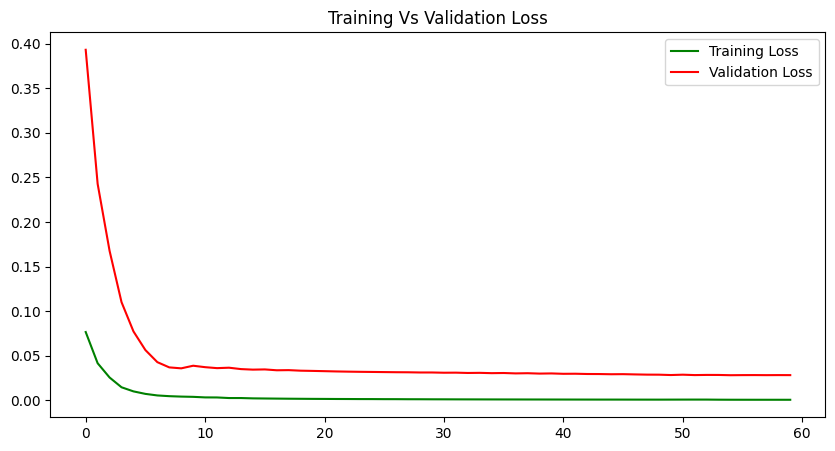

In [89]:
train_acc = history.history['loss']
val_acc = history.history['val_loss']

plt.figure(figsize = (10,5), dpi = 100)
plt.plot(train_acc, color = 'green', label = 'Training Loss')
plt.plot(val_acc, color = 'red', label = 'Validation Loss')
plt.title('Training Vs Validation Loss')
plt.legend()

In [91]:
pred = LSTM_model.predict(x_test)

pred = pred.reshape(-1,1)
target = y_test.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(target)

16/16 [==============================] - 0s 3ms/step


In [92]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

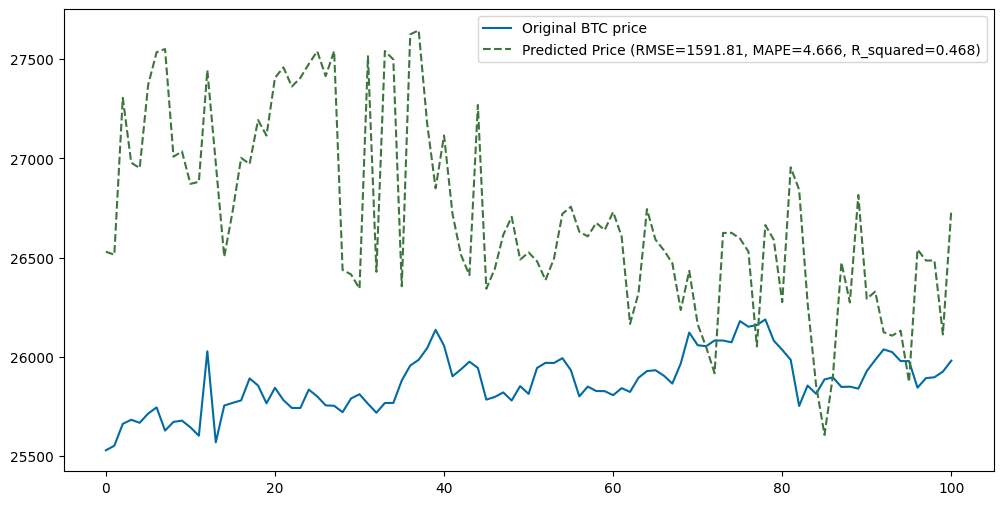

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### TKAN

In [38]:
x_train, y_train = lag_generator_1d_1output(scaled_train, windows = 1)
x_test, y_test = lag_generator_1d_1output(scaled_test, windows = 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8259, 43), (8259, 1), (499, 43), (499, 1))

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Enable mixed-precision training for speedup on compatible hardware
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Enable XLA (Accelerated Linear Algebra) for additional speedup
tf.config.optimizer.set_jit(True)

# Define Deep Spline Activation with tf.function for graph execution
class DeepSplineActivation(layers.Layer):
    def __init__(self, num_knots=10, **kwargs):
        super(DeepSplineActivation, self).__init__(**kwargs)
        self.num_knots = num_knots

    def build(self, input_shape):
        self.knots = self.add_weight(name='knots', 
                                     shape=(self.num_knots,),
                                     initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                     trainable=True)
        self.coefficients = self.add_weight(name='coefficients', 
                                            shape=(self.num_knots-1,),
                                            initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                            trainable=True)
        super(DeepSplineActivation, self).build(input_shape)

    @tf.function
    def call(self, inputs):
        # Assuming knots are pre-sorted during build time, sorting is not needed in every call
        sorted_knots = tf.sort(self.knots)
        differences = tf.nn.relu(inputs[..., None] - sorted_knots)
        spline_output = tf.reduce_sum(differences[..., :-1] * self.coefficients, axis=-1)
        return spline_output

# Define Kolmogorov-Arnold Network (KAN) with multiple neurons
def build_kan_model(input_shape, hidden_units=64, output_units=1, num_knots=10, num_neurons=5):
    inputs = tf.keras.Input(shape=input_shape)
    
    kan_neurons_outputs = []
    deep_spline_activation = DeepSplineActivation(num_knots=num_knots)
    
    for _ in range(num_neurons):
        x = layers.Dense(hidden_units)(inputs)
        x = layers.BatchNormalization()(x)  # Add BatchNormalization for faster convergence
        x = deep_spline_activation(x)
        
        x = layers.Dense(hidden_units)(x)
        x = layers.BatchNormalization()(x)  # Add BatchNormalization for faster convergence
        x = deep_spline_activation(x)
        
        kan_neurons_outputs.append(x)
    
    aggregated_output = layers.Concatenate()(kan_neurons_outputs)
    
    outputs = layers.Dense(output_units)(aggregated_output)
    
    kan_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return kan_model

# Define the LSTM model
def build_lstm_model(input_shape, lstm_units=64):
    model = models.Sequential()
    model.add(layers.LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(lstm_units))
    return model

# Combine LSTM and KAN models with multiple KAN neurons
def build_combined_model(input_shape, lstm_units=64, hidden_units=64, output_units=1, num_knots=10, num_neurons=5):
    lstm_input = tf.keras.Input(shape=input_shape)
    
    lstm_model = build_lstm_model(input_shape, lstm_units=lstm_units)
    lstm_output = lstm_model(lstm_input)
    
    # Flatten the output instead of using reshape (more efficient)
    reshaped_output = layers.Flatten()(lstm_output)
    
    kan_model = build_kan_model((reshaped_output.shape[-1],), hidden_units=hidden_units, output_units=output_units, num_knots=num_knots, num_neurons=num_neurons)
    kan_output = kan_model(reshaped_output)
    
    combined_model = tf.keras.Model(inputs=lstm_input, outputs=kan_output)
    return combined_model

In [55]:
from sklearn.metrics import r2_score
def perform_KAN(x_train, y_train, x_test, y_test, epochs = 100, batch_size = 16, lstm_units = 20, hidden_units = 20,
                output_units = 1, num_knots = 2, num_neurons = 5):
    
    trainX = x_train
    trainY = y_train
    testX = x_test
    testY = y_test
  
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # Build, compile, and train the model
    input_shape = (1, trainX.shape[2])

    model = build_combined_model(input_shape, lstm_units=lstm_units, hidden_units=hidden_units,
                                 output_units=output_units, num_knots=num_knots, num_neurons=num_neurons)

    model.compile(loss='mean_squared_error', optimizer = 'adam')
    
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size,verbose = 2)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainPredict = trainPredict.reshape(-1, trainPredict.shape[-1])
    testPredict = testPredict.reshape(-1, testPredict.shape[-1])

    return testPredict

In [75]:
KAN_predict = perform_KAN(x_train, y_train, x_test, y_test, epochs = 50, batch_size = 32, lstm_units = 43,
                          hidden_units = 1, output_units = 1, num_knots = 2, num_neurons = 1)

Epoch 1/50
259/259 - 7s - loss: 0.3501 - 7s/epoch - 28ms/step
Epoch 2/50
259/259 - 2s - loss: 0.1832 - 2s/epoch - 8ms/step
Epoch 3/50
259/259 - 1s - loss: 0.1109 - 1s/epoch - 6ms/step
Epoch 4/50
259/259 - 1s - loss: 0.0726 - 1s/epoch - 6ms/step
Epoch 5/50
259/259 - 1s - loss: 0.0523 - 1s/epoch - 5ms/step
Epoch 6/50
259/259 - 1s - loss: 0.0371 - 1s/epoch - 6ms/step
Epoch 7/50
259/259 - 1s - loss: 0.0299 - 1s/epoch - 6ms/step
Epoch 8/50
259/259 - 1s - loss: 0.0283 - 1s/epoch - 6ms/step
Epoch 9/50
259/259 - 1s - loss: 0.0247 - 1s/epoch - 5ms/step
Epoch 10/50
259/259 - 1s - loss: 0.0245 - 1s/epoch - 5ms/step
Epoch 11/50
259/259 - 1s - loss: 0.0225 - 1s/epoch - 6ms/step
Epoch 12/50
259/259 - 1s - loss: 0.0229 - 1s/epoch - 5ms/step
Epoch 13/50
259/259 - 1s - loss: 0.0214 - 1s/epoch - 5ms/step
Epoch 14/50
259/259 - 1s - loss: 0.0222 - 1s/epoch - 6ms/step
Epoch 15/50
259/259 - 1s - loss: 0.0232 - 1s/epoch - 5ms/step
Epoch 16/50
259/259 - 1s - loss: 0.0214 - 1s/epoch - 5ms/step
Epoch 17/50
259/

In [76]:
# pred = pred.reshape(-1,1)
target = y_test.reshape(-1,1)
pred = universal_y_enc.inverse_transform(KAN_predict)
unscaled_y = universal_y_enc.inverse_transform(target)

In [77]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

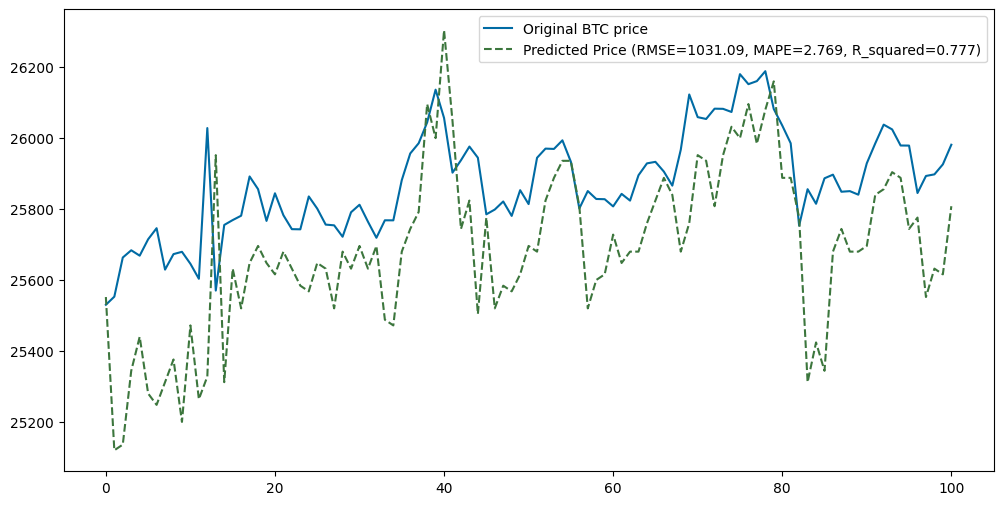

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");

### CNN LSTM

In [115]:
#Univariate
import random
def CNN_LSTM_lag_search(data, lag):
    random.seed(2)
    with tf.device('/cpu:0'):
        x_set, y_set = lag_generator_1out(data, windows = lag)
        input_train, output_train = x_set[0:len(x_set)-800], y_set[0:len(x_set)-800]
        input_test, output_test = x_set[len(x_set)-800:], y_set[len(x_set)-800:]
        
        input_train = input_train.reshape(input_train.shape[0], input_train.shape[1], input_train.shape[2], 1)
        input_test = input_test.reshape(input_test.shape[0], input_test.shape[1], input_test.shape[2], 1)
        
        grid_model = tf.keras.models.Sequential()

        grid_model.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 3, activation='relu'),
                                       input_shape=(None, input_train.shape[2], 1)))
        grid_model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
        grid_model.add(TimeDistributed(Flatten()))
        # Add a hidden layer with input dimensions, neurons and activation function

        grid_model.add(LSTM(units = input_train.shape[2], kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                            activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
        grid_model.add(Dropout(rate = 0))
        # Add output layer with one 1 ouput neuron as this is regression problem
        grid_model.add(Dense(1, activation = 'linear'))

        # Compile the model with optimizer and loss function
        grid_model.compile(optimizer = Adam(), loss = 'mse')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
    REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 2,
                                            factor = 0.5,
                                            min_lr = 1e-6,
                                            verbose = 0)

    # Train the model
    grid_model.fit(input_train, output_train, epochs = 100, batch_size = 16, validation_split = 0.2, shuffle = False,
                   callbacks = [callback, REDUCE_LR], verbose = 0)
    pred = grid_model.predict(input_test)

    pred = pred.reshape(-1, 1)
    pred = universal_y_enc.inverse_transform(pred)

    return rmse(output_test, pred)

# Call linear regression function and save error and r-squared as variable
error_list = []
lag_list = []
for i in range(1, 121):
    CNN_LSTM_error = CNN_LSTM_lag_search(scaled_train, i)
    error_list.append(CNN_LSTM_error)
    lag_list.append(i)
    print('Lag: ', str(i), " Error : " + str(CNN_LSTM_error))
    
errors = [abs(x) for x in error_list]
ind = errors.index(min(errors))
CNN_LSTM_best_lag = lag_list[ind]
print("==========CNN-LSTM results==========")
print("Best lag: ", str(CNN_LSTM_best_lag))

Epoch 16: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  1  Error : 26811.192207479846
Epoch 11: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  2  Error : 27007.06062492491
Epoch 11: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  3  Error : 27028.860265248255
Epoch 11: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  4  Error : 27102.87495590202
Epoch 11: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  5  Error : 27162.99616744062
Epoch 11: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  6  Error : 27053.825222920234
Epoch 11: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  7  Error : 27031.341816554228
Epoch 10: early stopping
25/25 [==============================] - 0s 3ms/step
Lag:  8  Error : 27123.53019217611
Epoch 10: early stopping
25/25 [==============================] - 0s 4ms/step
Lag:  9  Error

KeyboardInterrupt: 

In [94]:
x_train, y_train = lag_generator_1out(scaled_train, windows = 1)
x_test, y_test = lag_generator_1out(scaled_test, windows = 1)

In [95]:
x_train.shape

(8259, 1, 43)

In [96]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [101]:
with tf.device('/cpu:0'):
    # Create sequential model from tensorflow.keras
    CNN_LSTM_model = tf.keras.models.Sequential()
    
    CNN_LSTM_model.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 1, activation='relu'), input_shape=(None, 43, 1)))
    CNN_LSTM_model.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
    CNN_LSTM_model.add(TimeDistributed(Flatten()))
    # Add a hidden layer with input dimensions, neurons and activation function
    
    CNN_LSTM_model.add(LSTM(units = 43, kernel_initializer = 'he_uniform', bias_initializer = 'zeros',
                        activity_regularizer = tf.keras.regularizers.L2(l2 = 0)))
    CNN_LSTM_model.add(Dropout(rate = 0))
    # Add output layer with one 1 ouput neuron as this is regression problem
    CNN_LSTM_model.add(Dense(1, activation = 'linear'))
    CNN_LSTM_model.summary()

    # Compile the model with optimizer and loss function
    CNN_LSTM_model.compile(optimizer = Adam(), loss = 'mse')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 43, 32)     64        
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 21, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 672)        0         
 tributed)                                                       
                                                                 
 lstm_6 (LSTM)               (None, 43)                123152    
                                                                 
 dropout_6 (Dropout)         (None, 43)                0         
                                                      

In [102]:
# Define early stopping and learning rate reduction criteria
import random
random.seed(2)

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
REDUCE_LR = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience = 2,
                                        factor = 0.5,
                                        min_lr = 1e-6,
                                        verbose = 0)

# Train the model
#model_checkpoint = callbacks.ModelCheckpoint('Model/best_model', save_best_only = True)
history = CNN_LSTM_model.fit(x_train, y_train, epochs = 500, batch_size = 16, validation_split = 0.15, shuffle = True,
                        callbacks = [callback, REDUCE_LR])

Epoch 1/500
439/439 [==============================] - 6s 7ms/step - loss: 0.0280 - val_loss: 0.0156 - lr: 0.0010
Epoch 2/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0052 - val_loss: 0.0204 - lr: 0.0010
Epoch 3/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0032 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0031 - val_loss: 0.0091 - lr: 0.0010
Epoch 5/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0021 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0021 - val_loss: 0.0103 - lr: 0.0010
Epoch 7/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0025 - val_loss: 0.0090 - lr: 0.0010
Epoch 8/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0015 - val_loss: 0.0043 - lr: 5.0000e-04
Epoch 9/500
439/439 [==============================] - 3s 6ms/step - loss: 0.0011 - 

In [103]:
pred = CNN_LSTM_model.predict(x_test)

pred = pred.reshape(-1,1)
target = y_test.reshape(-1,1)
pred = universal_y_enc.inverse_transform(pred)
unscaled_y = universal_y_enc.inverse_transform(target)

16/16 [==============================] - 0s 4ms/step


In [104]:
rmse_error = rmse(unscaled_y, pred)
mape_error = MAPE(unscaled_y, pred)
r2 = r2_score(unscaled_y, pred)

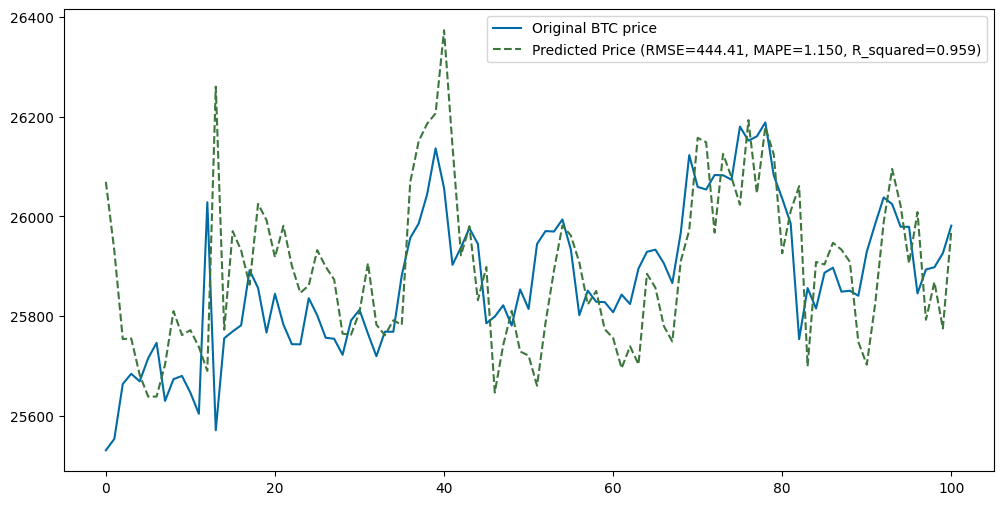

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(unscaled_y[0:101], label = 'Original BTC price')
ax.plot(pred[0:101], linestyle='--', color='#3c763d',
        label="Predicted Price (RMSE={:0.2f}, MAPE={:0.3f}, R_squared={:0.3f})".format(rmse_error, float(mape_error), r2))

ax.legend();
ax.set_title("");